In [3]:
import os, glob
import sys
import copy 
import pydicom
import random
import re
import scipy
import scipy.misc
import numpy as np
import cv2
import imageio
import keras
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.losses import *
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image, ImageEnhance
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from scipy.ndimage import rotate
from skimage import exposure
from sklearn.metrics import confusion_matrix
from operator import add 
plt.set_cmap('gray')
%matplotlib inline
seed = 42
random.seed = seed
np.random.seed = seed
tf.seed = seed


IMG_DTYPE = float
SEG_DTYPE = np.uint8

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda, Activation, Reshape
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.metrics import Recall, Precision


<Figure size 640x480 with 0 Axes>

In [5]:
masks_path = os.path.join('train','masks')
training_path = os.path.join('train','patients')

In [6]:
def imshow(*images, **kwargs):
    """
    Display one or more images using matplotlib.
    
    Parameters:
    - images: One or more images to be displayed.
    - cmap: Colormap to be used (default: 'gray').
    - title: Title for the image plot or a list of titles for each image.
    """
    
    num_images = len(images)
    
    if num_images == 0:
        raise ValueError("No images provided to imshow function.")
    
    cmap = kwargs.get('cmap', 'gray')
    title = kwargs.get('title', '')
    
    # Ensure cmap and title are lists of the same length as images
    if isinstance(cmap, str):
        cmap = [cmap] * num_images
    if isinstance(title, str):
        title = [title] * num_images

    plt.figure(figsize=(num_images * 5, 10))
    
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i], cmap=cmap[i], interpolation='none')
        plt.title(title[i])
        plt.axis('off')
    
    plt.show()

def normalize_image(img):
    """
    Normalize image pixel values to the range [0, 1].
    
    Parameters:
    - img: Image to be normalized.
    
    Returns:
    - Normalized image.
    """
    min_val, max_val = float(np.min(img)), float(np.max(img))
    return (img - min_val) / (max_val - min_val)

def dice(im1, im2):
    """
    Compute the Dice similarity coefficient between two binary images.
    
    Parameters:
    - im1, im2: Input binary images.
    
    Returns:
    - Dice similarity coefficient.
    """
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / (im1.sum() + im2.sum())


In [16]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self, id_name):

        tumor_volume = None
        
        image_path = os.path.join(self.path,"patients", id_name)
        mask_path = os.path.join(self.path,"masks")
        all_masks = os.listdir(mask_path)
        dicom_image = pydicom.dcmread(image_path)
        
        image = step1_preprocess_img_slice(dicom_image.pixel_array)
       
        liver_mask_id = id_name.split('_')
        liver_mask = pydicom.dcmread(os.path.join(mask_path, liver_mask_id[0]+'_liver', id_name)).pixel_array
        
        image = np.multiply(image,np.clip(liver_mask,0,1))
        
        image = np.array(Image.fromarray(image).resize([image_size, image_size])).astype(IMG_DTYPE)
        mask = cv2.imread(os.path.join(masks_path,'merged_livertumors', id_name+'.jpg'))
        
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        retval, mask = cv2.threshold(mask, 100, 255, cv2.THRESH_BINARY)
        mask = np.array(Image.fromarray(mask).resize([image_size, image_size])).astype(IMG_DTYPE)
        mask = mask // 255
        
        mask = mask[:, :, np.newaxis]
        
        return image, mask
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
#         print(files_batch)
        image = []
        mask  = []
        for id_name in files_batch:

            _img, _mask = self.__load__(id_name)
            _img = np.stack((_img,)*3, axis=-1)
            image.append(_img)
            mask.append(_mask)
        
        image = np.array(image)
        mask  = np.array(mask)

        return image, mask
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))
    


In [17]:
image_size =  256
train_path = "train"
batch_size = 8
epochs = 100
## Training Ids
images = []
for file in os.listdir(os.path.join(train_path, "patients")):

    images.append(file)


## Validation Data Size
val_data_size = len(images)//5 # 20% validation Data
# factor = 0
valid_ids = images[:val_data_size]
train_ids = images[val_data_size:]
print(len(train_ids))

2259


In [18]:
def step1_preprocess_img_slice(img_slc):
    """
    Preprocesses the image 3d volumes by performing the following :
    1- Set pixels with hounsfield value great than 1200, to zero.
    2- Clip all hounsfield values to the range [-100, 400]
    3- Apply Histogram Equalization
    """    
    
    # Set pixels with Hounsfield values greater than 1200 to zero
    slice_data[slice_data > 1000] = 0
    
    # Clip Hounsfield values to the range [-100, 400]
    slice_data = np.clip(slice_data, -100, 400)
    
    # Normalize image pixel values to [0, 1]
    slice_data = normalize_image_values(slice_data)
    
    # Convert normalized values to range [0, 255]
    slice_data_uint8 = (slice_data * 255).astype('uint8')
    
    # Apply histogram equalization
    equalized_slice_data = cv2.equalizeHist(slice_data_uint8)
    
    # Normalize the pixel values of equalized data
    normalized_equalized_slice = normalize_image_values(equalized_slice_data)
    
    return normalized_equalized_slice


In [19]:
gen = DataGen(train_ids, train_path, batch_size=batch_size, image_size=image_size)
x, y = gen.__getitem__(10)
print(x.shape,y.shape)

(8, 256, 256, 3) (8, 256, 256, 1)


0


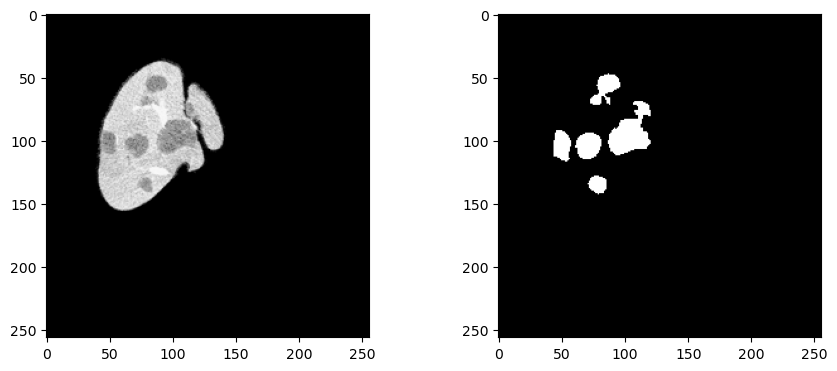

In [213]:
r = random.randint(0, len(x)-1)
r = 0
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(1, 2, 1)
ax.imshow(x[r])
print(r)
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(y[r], (image_size, image_size)), cmap="gray")

In [224]:
def convBlock(input, filters, kernel, kernel_init='he_normal', act='relu', transpose=True):
  if transpose == False:
    #conv = ZeroPadding2D((1,1))(input)
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
  else:
    #conv = ZeroPadding2D((1,1))(input)
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)

  conv = Activation(act)(conv)
  return conv


def convBlock2(input, filters, kernel, kernel_init='he_normal', act='relu', transpose=True):
  if transpose == False:
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
    conv = Activation(act)(conv)
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(conv)
    conv = Activation(act)(conv)
  else:
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
    conv = Activation(act)(conv)
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(conv)
    conv = Activation(act)(conv)

  return conv
  
'''
  Attention block/mechanism
'''
def attention_block(x, gating, inter_shape, drop_rate=0.25):
   
    # Find shape of inputs
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

    ## Process x vector and gating signal
    # x vector input and processing
    theta_x = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation='softmax')(x)
    theta_x = MaxPooling2D((2,2))(theta_x)
    shape_theta_x = K.int_shape(theta_x)

    # gating signal ""
    phi_g = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation='softmax')(gating)
    shape_phi_g = K.int_shape(phi_g)

    # Add components
    concat_xg = add([phi_g, theta_x])
    act_xg = Activation('relu')(concat_xg)

    # Apply convolution
    psi = Conv2D(1, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation='softmax')(act_xg)

    # Apply sigmoid activation
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)

    # UpSample and resample to correct size
    upsample_psi = UpSampling2D(interpolation='bilinear', size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)
    upsample_psi = tf.image.resize(upsample_psi, (shape_x[1], shape_x[2]))  # Resize upsample_psi
    y = multiply([upsample_psi, x])

    return y


'''
  Attention U-Net model
'''

def UNetAM(trained_weights = None, input_size = (256,256,3), drop_rate = 0.25, lr=0.00001, filter_base=16):

    ## Can add pretrained weights by specifying 'trained_weights'

    # Input layer
    inputs = Input(input_size, batch_size=1)

    ## Contraction phase
    conv = convBlock2(inputs, filter_base, 3)
    #conv0 = Dropout(drop_rate)(conv0)

    conv0 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv0 = convBlock2(conv0, 2 * filter_base, 3)

    pool0 = MaxPooling2D(pool_size=(2, 2))(conv0)
    conv1 = convBlock2(pool0, 4 * filter_base, 3)
    #conv1 = Dropout(drop_rate)(conv1)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = convBlock2(pool1, 8 * filter_base, 3)
    #conv2 = Dropout(drop_rate)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = convBlock2(pool2, 16 * filter_base, 3)
    #conv3 = Dropout(drop_rate)(conv3)

    ## Expansion phase
    up4 = (Conv2DTranspose(8 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv3))
    merge4 = attention_block(conv2, conv3, 8 * filter_base, drop_rate) # Attention gate
    conv4 = concatenate([up4, merge4])
    conv4 = convBlock2(conv4, 8 * filter_base, 3)

    up5 = (Conv2DTranspose(4 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv4))
    merge5 = attention_block(conv1, conv4, 4 * filter_base, drop_rate) # Attention gate
    conv5 = concatenate([up5, merge5])
    conv5 = convBlock2(conv5, 4 * filter_base, 3)

    up6 = (Conv2DTranspose(2 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv5))
    merge6 = attention_block(conv0, conv5, 2 * filter_base, drop_rate) # Attention gate
    conv6 = concatenate([up6, merge6])
    conv6 = convBlock2(conv6, 2 * filter_base, 3)

    up7 = (Conv2DTranspose(1 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv6))
    merge7 = attention_block(conv, conv6, 1 * filter_base, drop_rate) # Attention gate
    conv7 = concatenate([up7, merge7])
    conv7 = concatenate([up7, conv])
    conv7 = convBlock2(conv7, 1 * filter_base, 3)

    ## Output layer
    out = convBlock(conv7, 1, 1, act='sigmoid')

    model = Model(inputs, out)

#     model.compile(optimizer = adam_v2.Adam(learning_rate = lr), loss = binary_crossentropy, metrics = ['accuracy', 'mse'])

    if trained_weights != None:
      model.load_weights(trained_weights)

    return model

In [225]:
smooth = 1e-15

def dice_coef(y_true, y_pred):
    y_true_f = keras.layers.Flatten()(y_true)
    y_pred_f = y_true_f = keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def iou(y_true,y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + 1e-15) / (union + 1e-15)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

def dice_coef_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [226]:
model = UNetAM()
adam = tf.keras.optimizers.legacy.Adam()
model.compile(optimizer=adam, loss='binary_crossentropy', metrics=["acc", dice_coef, iou, Recall(), Precision()])
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_345 (Conv2D)         (None, 256, 256, 32)         896       ['input_15[0][0]']            
                                                                                                  
 batch_normalization_224 (B  (None, 256, 256, 32)         128       ['conv2d_345[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_297 (Activation  (None, 256, 256, 32)         0         ['batch_normalization_2

 atchNormalization)                                                                               
                                                                                                  
 conv2d_356 (Conv2D)         (None, 32, 32, 256)          33024     ['add_94[0][0]']              
                                                                                                  
 activation_303 (Activation  (None, 32, 32, 256)          0         ['batch_normalization_233[0][0
 )                                                                  ]']                           
                                                                                                  
 batch_normalization_234 (B  (None, 32, 32, 256)          1024      ['conv2d_356[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 conv2d_35

                                                                                                  
 add_97 (Add)                (None, 32, 32, 512)          0         ['batch_normalization_242[0][0
                                                                    ]',                           
                                                                     'conv2d_363[0][0]']          
                                                                                                  
 up_sampling2d_53 (UpSampli  (None, 64, 64, 512)          0         ['add_97[0][0]']              
 ng2D)                                                                                            
                                                                                                  
 concatenate_58 (Concatenat  (None, 64, 64, 640)          0         ['up_sampling2d_53[0][0]',    
 e)                                                                  'add_94[0][0]']              
          

                                                                                                  
 conv2d_373 (Conv2D)         (None, 256, 256, 64)         10304     ['concatenate_60[0][0]']      
                                                                                                  
 activation_315 (Activation  (None, 256, 256, 64)         0         ['batch_normalization_250[0][0
 )                                                                  ]']                           
                                                                                                  
 batch_normalization_251 (B  (None, 256, 256, 64)         256       ['conv2d_373[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 conv2d_372 (Conv2D)         (None, 256, 256, 64)         36928     ['activation_315[0][0]']      
          

In [227]:
train_gen = DataGen(train_ids, train_path, image_size=image_size, batch_size=batch_size)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)
# test_gen  = DataGenTest(train_ids, train_path, image_size=image_size, batch_size=batch_size)

train_steps = len(train_ids)//batch_size
valid_steps = len(valid_ids)//batch_size


logger_path = os.path.join("Liver-tumor-segmentation.csv")
path_ = "Dataset"

callbacks = [
    ModelCheckpoint(path_, verbose=1, save_best_only=True, monitor='val_loss'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=10, min_lr=1e-7,verbose=1),
    CSVLogger(logger_path),
    TensorBoard(),
    EarlyStopping(monitor='val_loss',patience=50,restore_best_weights=False)
]

model_history = model.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, 
                    epochs=epochs, shuffle=True, callbacks=callbacks)

Epoch 1/100
2327/2327 [==============================] - ETA: 0s - loss: 0.0154 - acc: 0.9948 - dice_coef: 0.4978 - iou: 0.3307 - recall: 0.5770 - precision: 0.6927
Epoch 1: val_loss improved from inf to 0.02508, saving model to Dataset
INFO:tensorflow:Assets written to: Dataset/assets


INFO:tensorflow:Assets written to: Dataset/assets


2327/2327 [==============================] - 16495s 7s/step - loss: 0.0154 - acc: 0.9948 - dice_coef: 0.4978 - iou: 0.3307 - recall: 0.5770 - precision: 0.6927 - val_loss: 0.0251 - val_acc: 0.9925 - val_dice_coef: 0.0995 - val_iou: 0.0684 - val_recall: 7.8576e-04 - val_precision: 0.7160 - lr: 0.0010
Epoch 2/100
2327/2327 [==============================] - ETA: 0s - loss: 0.0151 - acc: 0.9942 - dice_coef: 0.3611 - iou: 0.2027 - recall: 0.4433 - precision: 0.6766
Epoch 2: val_loss did not improve from 0.02508
2327/2327 [==============================] - 2598s 1s/step - loss: 0.0151 - acc: 0.9942 - dice_coef: 0.3611 - iou: 0.2027 - recall: 0.4433 - precision: 0.6766 - val_loss: 0.0482 - val_acc: 0.9735 - val_dice_coef: 0.4913 - val_iou: 0.0888 - val_recall: 0.3991 - val_precision: 0.1201 - lr: 0.0010
Epoch 3/100
2327/2327 [==============================] - ETA: 0s - loss: 0.0114 - acc: 0.9955 - dice_coef: 0.4221 - iou: 0.2577 - recall: 0.6073 - precision: 0.7379
Epoch 3: val_loss did not 

INFO:tensorflow:Assets written to: Dataset/assets


2327/2327 [==============================] - 11439s 5s/step - loss: 0.0079 - acc: 0.9971 - dice_coef: 0.5000 - iou: 0.3575 - recall: 0.7729 - precision: 0.8452 - val_loss: 0.0220 - val_acc: 0.9936 - val_dice_coef: 0.5120 - val_iou: 0.2557 - val_recall: 0.3828 - val_precision: 0.6212 - lr: 0.0010
Epoch 7/100
2327/2327 [==============================] - ETA: 0s - loss: 0.0075 - acc: 0.9972 - dice_coef: 0.4892 - iou: 0.3477 - recall: 0.7667 - precision: 0.8474
Epoch 7: val_loss did not improve from 0.02197
2327/2327 [==============================] - 10209s 4s/step - loss: 0.0075 - acc: 0.9972 - dice_coef: 0.4892 - iou: 0.3477 - recall: 0.7667 - precision: 0.8474 - val_loss: 0.1417 - val_acc: 0.9579 - val_dice_coef: 0.8728 - val_iou: 0.1254 - val_recall: 0.6793 - val_precision: 0.1141 - lr: 0.0010
Epoch 8/100
2327/2327 [==============================] - ETA: 0s - loss: 0.0066 - acc: 0.9976 - dice_coef: 0.5164 - iou: 0.3860 - recall: 0.8141 - precision: 0.8696
Epoch 8: val_loss did not imp

INFO:tensorflow:Assets written to: Dataset/assets


2327/2327 [==============================] - 2580s 1s/step - loss: 0.0058 - acc: 0.9979 - dice_coef: 0.5336 - iou: 0.4088 - recall: 0.8400 - precision: 0.8790 - val_loss: 0.0206 - val_acc: 0.9940 - val_dice_coef: 0.3972 - val_iou: 0.2101 - val_recall: 0.2828 - val_precision: 0.7708 - lr: 0.0010
Epoch 11/100
2327/2327 [==============================] - ETA: 0s - loss: 0.0058 - acc: 0.9978 - dice_coef: 0.5311 - iou: 0.4041 - recall: 0.8320 - precision: 0.8720
Epoch 11: val_loss did not improve from 0.02056
2327/2327 [==============================] - 2578s 1s/step - loss: 0.0058 - acc: 0.9978 - dice_coef: 0.5311 - iou: 0.4041 - recall: 0.8320 - precision: 0.8720 - val_loss: 0.0290 - val_acc: 0.9939 - val_dice_coef: 0.4220 - val_iou: 0.1850 - val_recall: 0.2066 - val_precision: 0.9483 - lr: 0.0010
Epoch 12/100
2327/2327 [==============================] - ETA: 0s - loss: 0.0050 - acc: 0.9982 - dice_coef: 0.5575 - iou: 0.4330 - recall: 0.8586 - precision: 0.8940
Epoch 12: val_loss did not i

INFO:tensorflow:Assets written to: Dataset/assets


2327/2327 [==============================] - 2580s 1s/step - loss: 0.0048 - acc: 0.9982 - dice_coef: 0.5478 - iou: 0.4308 - recall: 0.8609 - precision: 0.8940 - val_loss: 0.0199 - val_acc: 0.9944 - val_dice_coef: 0.6027 - val_iou: 0.3275 - val_recall: 0.4740 - val_precision: 0.6909 - lr: 0.0010
Epoch 14/100
2327/2327 [==============================] - ETA: 0s - loss: 0.0046 - acc: 0.9983 - dice_coef: 0.5552 - iou: 0.4396 - recall: 0.8718 - precision: 0.9015
Epoch 14: val_loss did not improve from 0.01990
2327/2327 [==============================] - 2582s 1s/step - loss: 0.0046 - acc: 0.9983 - dice_coef: 0.5552 - iou: 0.4396 - recall: 0.8718 - precision: 0.9015 - val_loss: 0.0312 - val_acc: 0.9924 - val_dice_coef: 0.7821 - val_iou: 0.3565 - val_recall: 0.5431 - val_precision: 0.4956 - lr: 0.0010
Epoch 15/100
2327/2327 [==============================] - ETA: 0s - loss: 0.0044 - acc: 0.9984 - dice_coef: 0.5646 - iou: 0.4515 - recall: 0.8799 - precision: 0.9117
Epoch 15: val_loss did not i

Epoch 45/100
2327/2327 [==============================] - ETA: 0s - loss: 0.0024 - acc: 0.9991 - dice_coef: 0.6472 - iou: 0.5592 - recall: 0.9322 - precision: 0.9448
Epoch 45: val_loss did not improve from 0.01990
2327/2327 [==============================] - 2612s 1s/step - loss: 0.0024 - acc: 0.9991 - dice_coef: 0.6472 - iou: 0.5592 - recall: 0.9322 - precision: 0.9448 - val_loss: 0.0323 - val_acc: 0.9941 - val_dice_coef: 0.7811 - val_iou: 0.3652 - val_recall: 0.4695 - val_precision: 0.6477 - lr: 1.0000e-06
Epoch 46/100
2327/2327 [==============================] - ETA: 0s - loss: 0.0025 - acc: 0.9991 - dice_coef: 0.6568 - iou: 0.5685 - recall: 0.9321 - precision: 0.9466
Epoch 46: val_loss did not improve from 0.01990
2327/2327 [==============================] - 2657s 1s/step - loss: 0.0025 - acc: 0.9991 - dice_coef: 0.6568 - iou: 0.5685 - recall: 0.9321 - precision: 0.9466 - val_loss: 0.0315 - val_acc: 0.9946 - val_dice_coef: 0.7885 - val_iou: 0.3807 - val_recall: 0.4713 - val_precisi

Epoch 61/100
2327/2327 [==============================] - ETA: 0s - loss: 0.0024 - acc: 0.9991 - dice_coef: 0.6513 - iou: 0.5628 - recall: 0.9355 - precision: 0.9476
Epoch 61: val_loss did not improve from 0.01990
2327/2327 [==============================] - 2594s 1s/step - loss: 0.0024 - acc: 0.9991 - dice_coef: 0.6513 - iou: 0.5628 - recall: 0.9355 - precision: 0.9476 - val_loss: 0.0325 - val_acc: 0.9943 - val_dice_coef: 0.7892 - val_iou: 0.3733 - val_recall: 0.4692 - val_precision: 0.6715 - lr: 1.0000e-07
Epoch 62/100
2327/2327 [==============================] - ETA: 0s - loss: 0.0024 - acc: 0.9991 - dice_coef: 0.6575 - iou: 0.5727 - recall: 0.9353 - precision: 0.9484
Epoch 62: val_loss did not improve from 0.01990
2327/2327 [==============================] - 2587s 1s/step - loss: 0.0024 - acc: 0.9991 - dice_coef: 0.6575 - iou: 0.5727 - recall: 0.9353 - precision: 0.9484 - val_loss: 0.0338 - val_acc: 0.9940 - val_dice_coef: 0.7966 - val_iou: 0.3727 - val_recall: 0.4842 - val_precisi

In [35]:
# model.save('tumor_model_50epochs.keras')  # creates a HDF5 file 'my_model.h5'
# model.save_weights("tumor_weights_final_50epochs.keras")
# model.save(os.path.join('models','tumor_model_50epochs.keras'))  
model = keras.models.load_model(os.path.join('models','tumor_model_50epochs.keras'),compile=False)
valid_gen = DataGen(valid_ids, train_path, image_size=image_size, batch_size=batch_size)
model.summary()

# del model

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d_345 (Conv2D)         (None, 256, 256, 32)         896       ['input_15[0][0]']            
                                                                                                  
 batch_normalization_224 (B  (None, 256, 256, 32)         128       ['conv2d_345[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_297 (Activation  (None, 256, 256, 32)         0         ['batch_normalization_2

 atchNormalization)                                                                               
                                                                                                  
 conv2d_356 (Conv2D)         (None, 32, 32, 256)          33024     ['add_94[0][0]']              
                                                                                                  
 activation_303 (Activation  (None, 32, 32, 256)          0         ['batch_normalization_233[0][0
 )                                                                  ]']                           
                                                                                                  
 batch_normalization_234 (B  (None, 32, 32, 256)          1024      ['conv2d_356[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 conv2d_35

                                                                                                  
 add_97 (Add)                (None, 32, 32, 512)          0         ['batch_normalization_242[0][0
                                                                    ]',                           
                                                                     'conv2d_363[0][0]']          
                                                                                                  
 up_sampling2d_53 (UpSampli  (None, 64, 64, 512)          0         ['add_97[0][0]']              
 ng2D)                                                                                            
                                                                                                  
 concatenate_58 (Concatenat  (None, 64, 64, 640)          0         ['up_sampling2d_53[0][0]',    
 e)                                                                  'add_94[0][0]']              
          

                                                                                                  
 conv2d_373 (Conv2D)         (None, 256, 256, 64)         10304     ['concatenate_60[0][0]']      
                                                                                                  
 activation_315 (Activation  (None, 256, 256, 64)         0         ['batch_normalization_250[0][0
 )                                                                  ]']                           
                                                                                                  
 batch_normalization_251 (B  (None, 256, 256, 64)         256       ['conv2d_373[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 conv2d_372 (Conv2D)         (None, 256, 256, 64)         36928     ['activation_315[0][0]']      
          

1/1 [==============================] - 2s 2s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


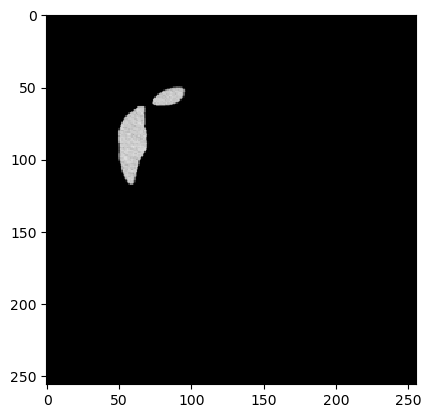

In [36]:
x, y = valid_gen.__getitem__(40)
result = model.predict(x)

result = result > 0.5

imshow(x[1])


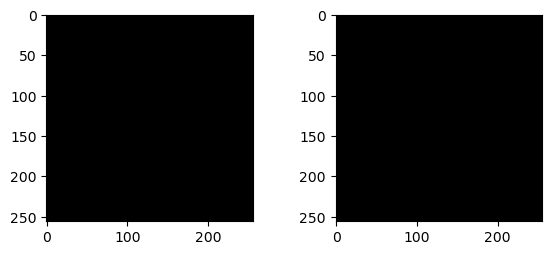

In [37]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[1]*255, (image_size, image_size)), cmap="gray")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[1]*255, (image_size, image_size)), cmap="gray")

1/1 [==============================] - 2s 2s/step


/var/folders/w7/y5klds4x3_53168tgqlttv6w0000gn/T/ipykernel_24010/2402579901.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(20,20))


1/1 [==============================] - 2s 2s/step


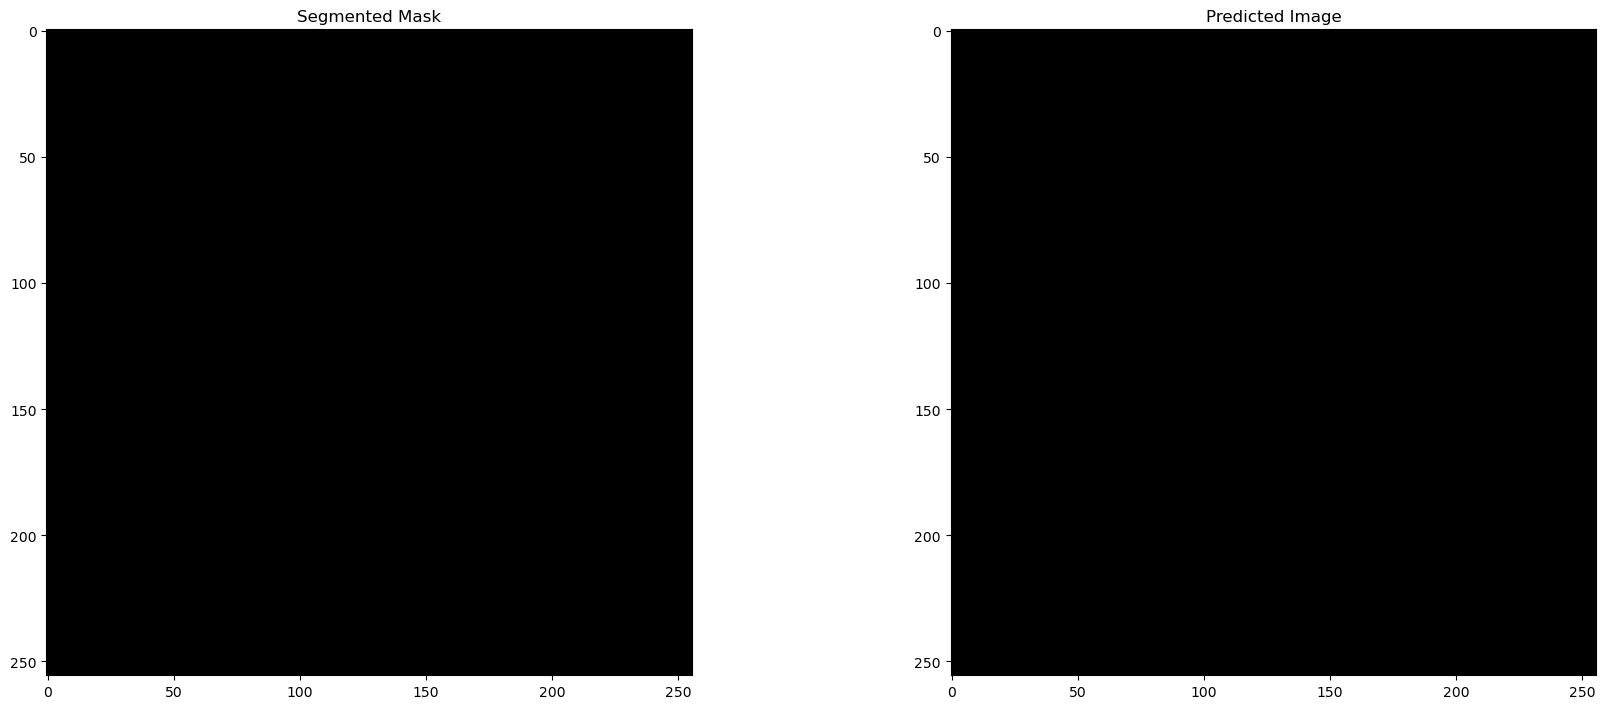

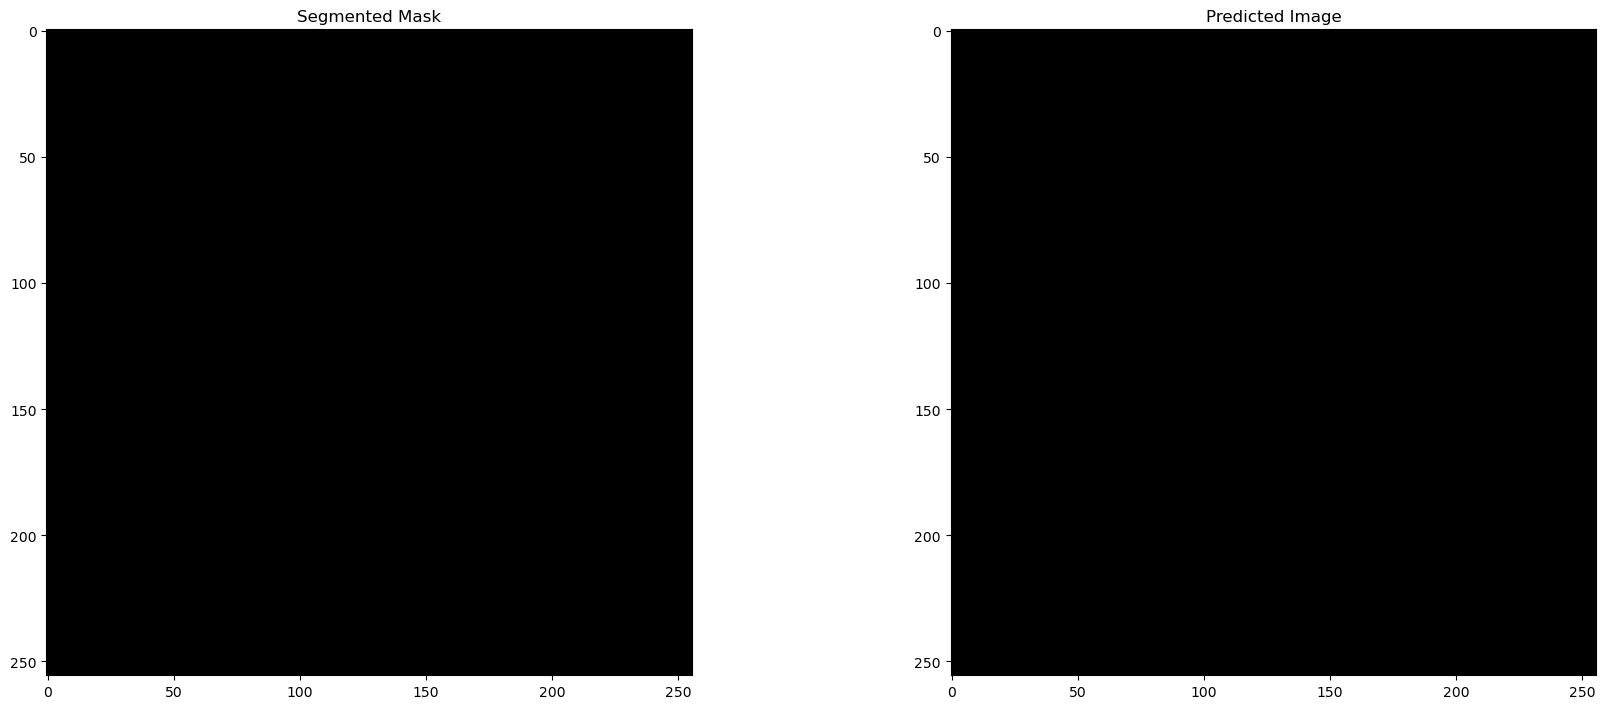

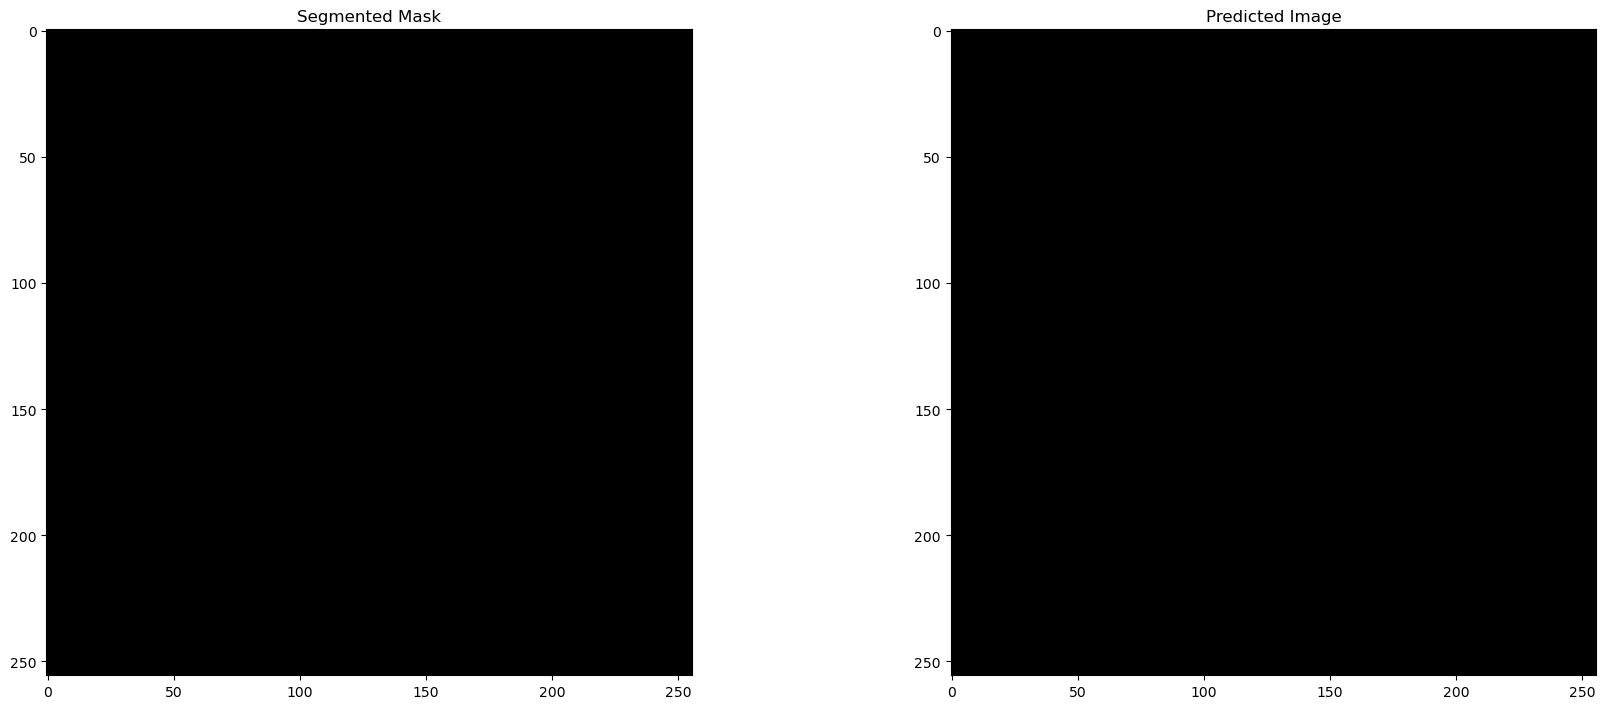

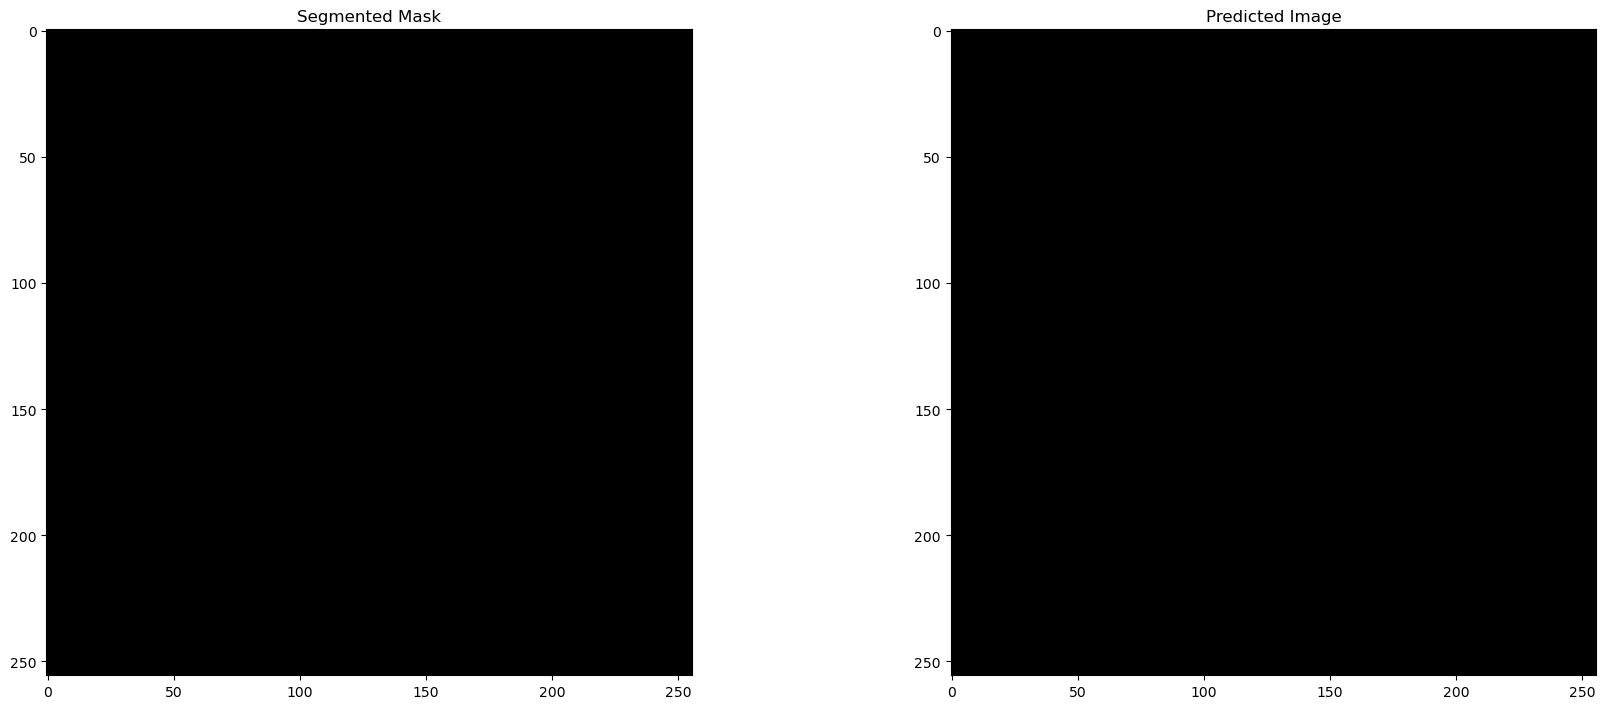

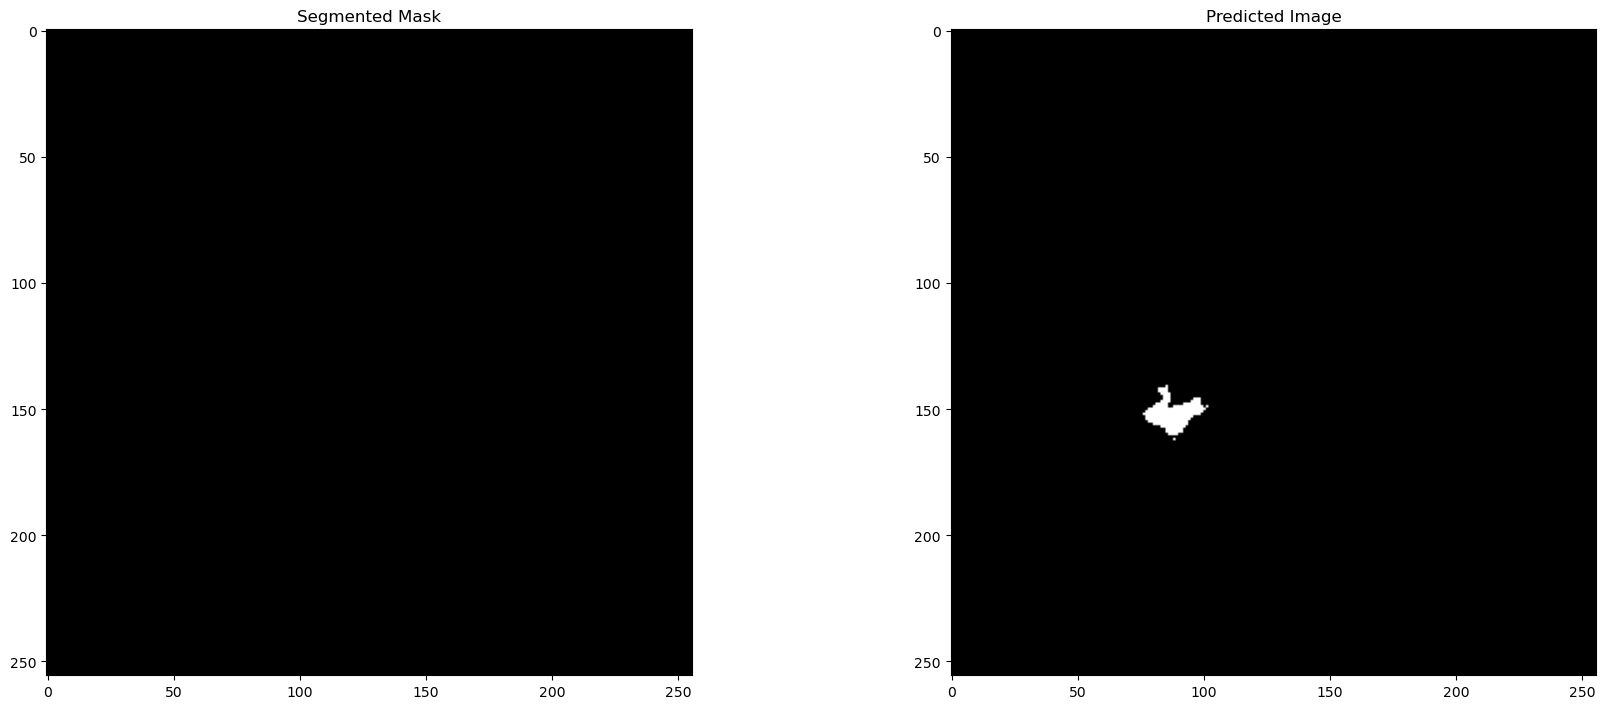

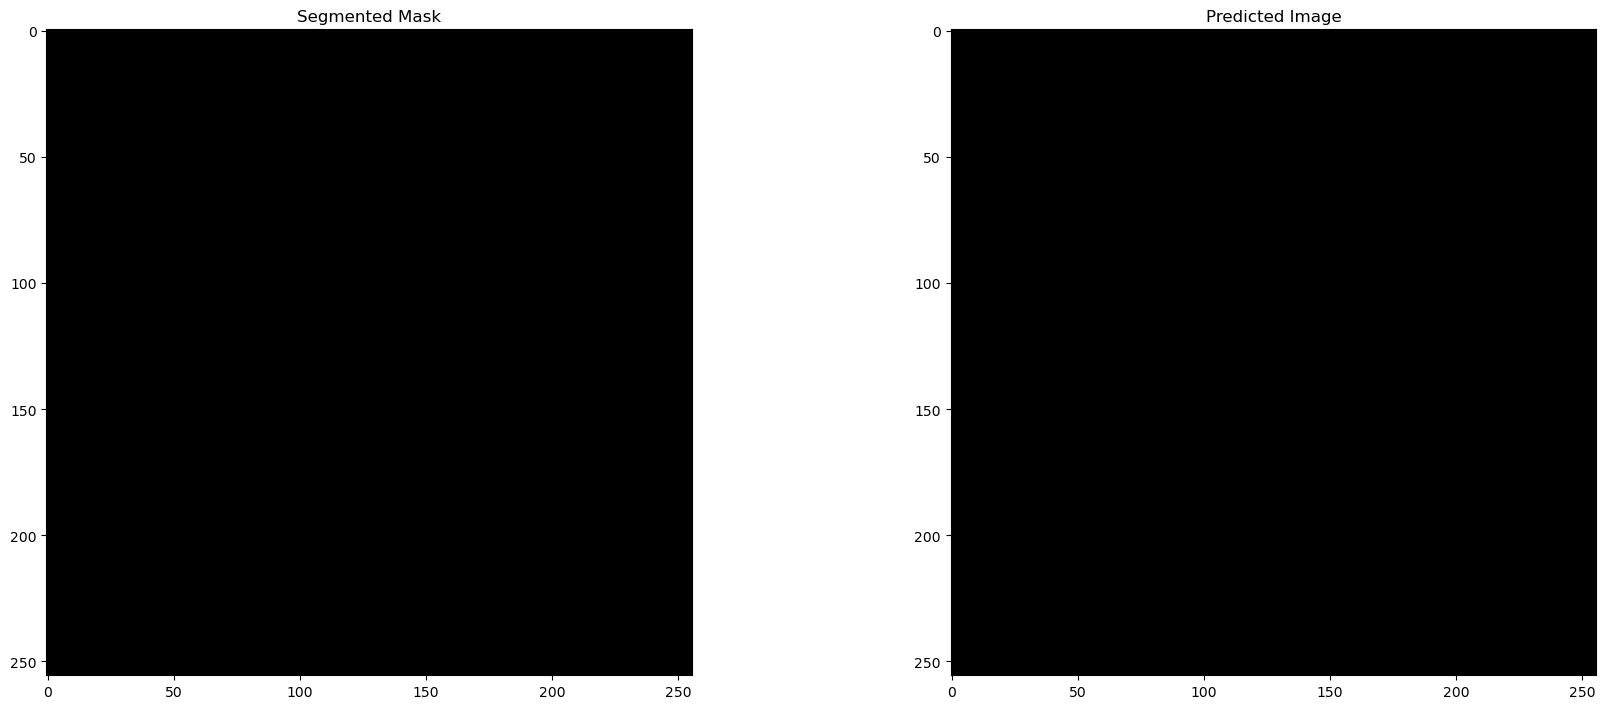

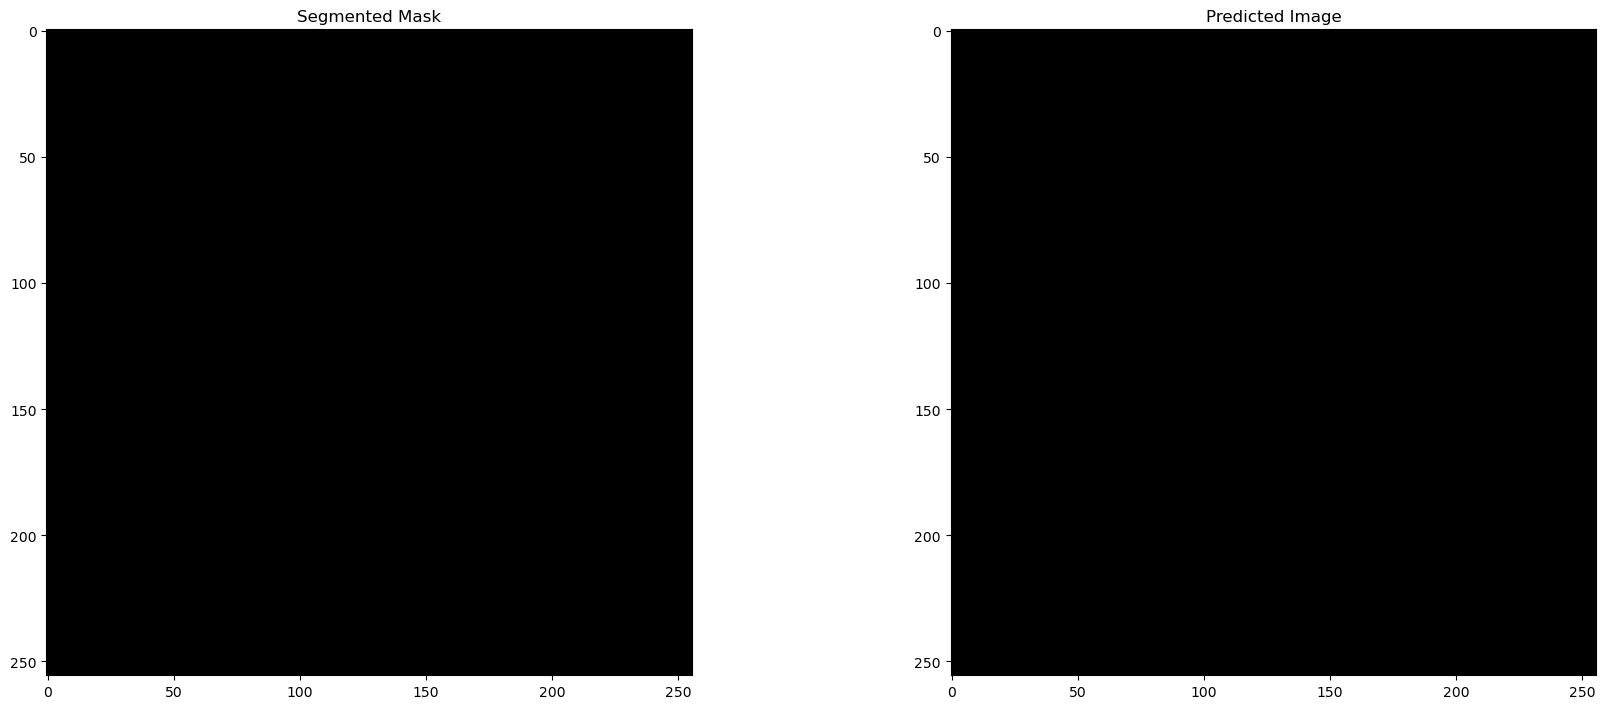

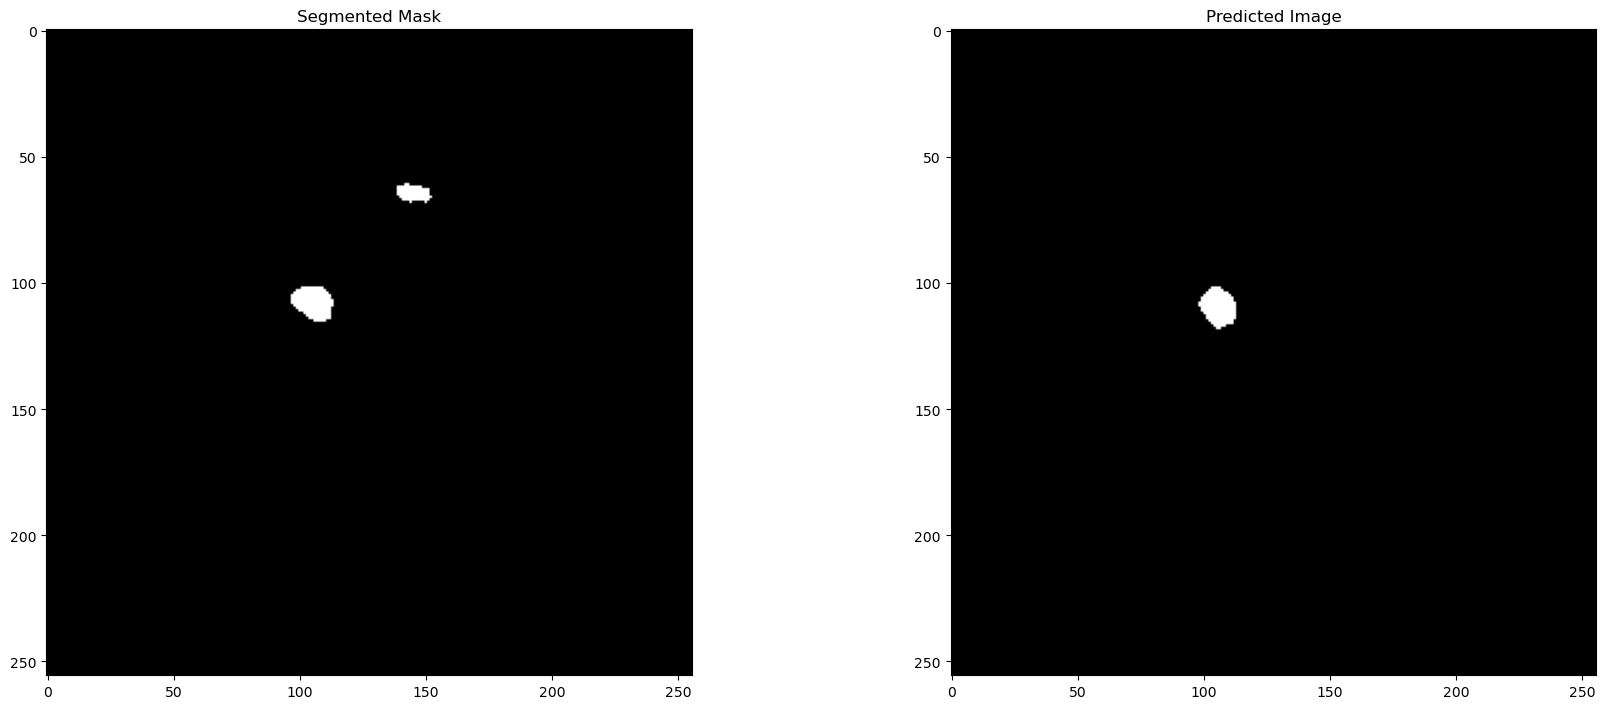

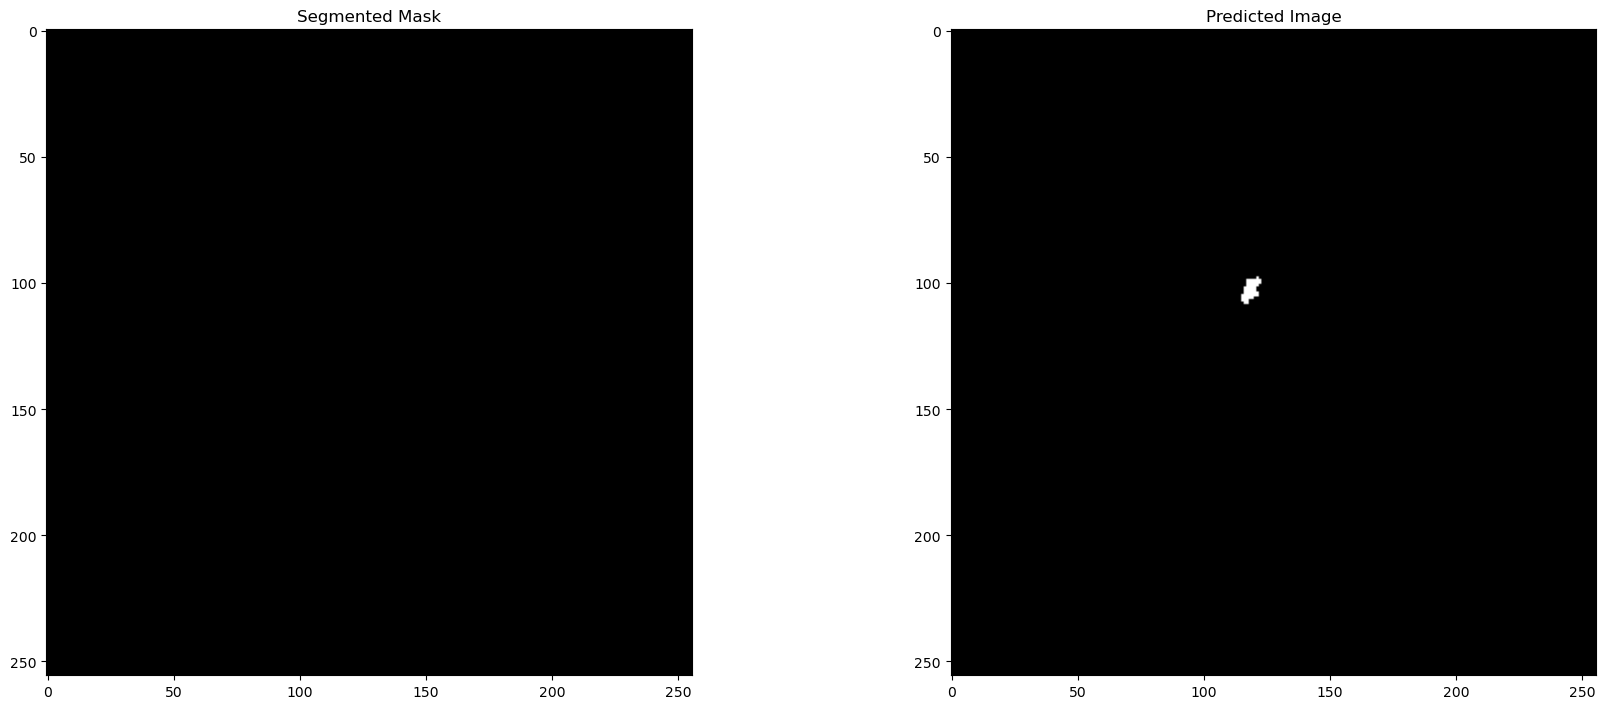

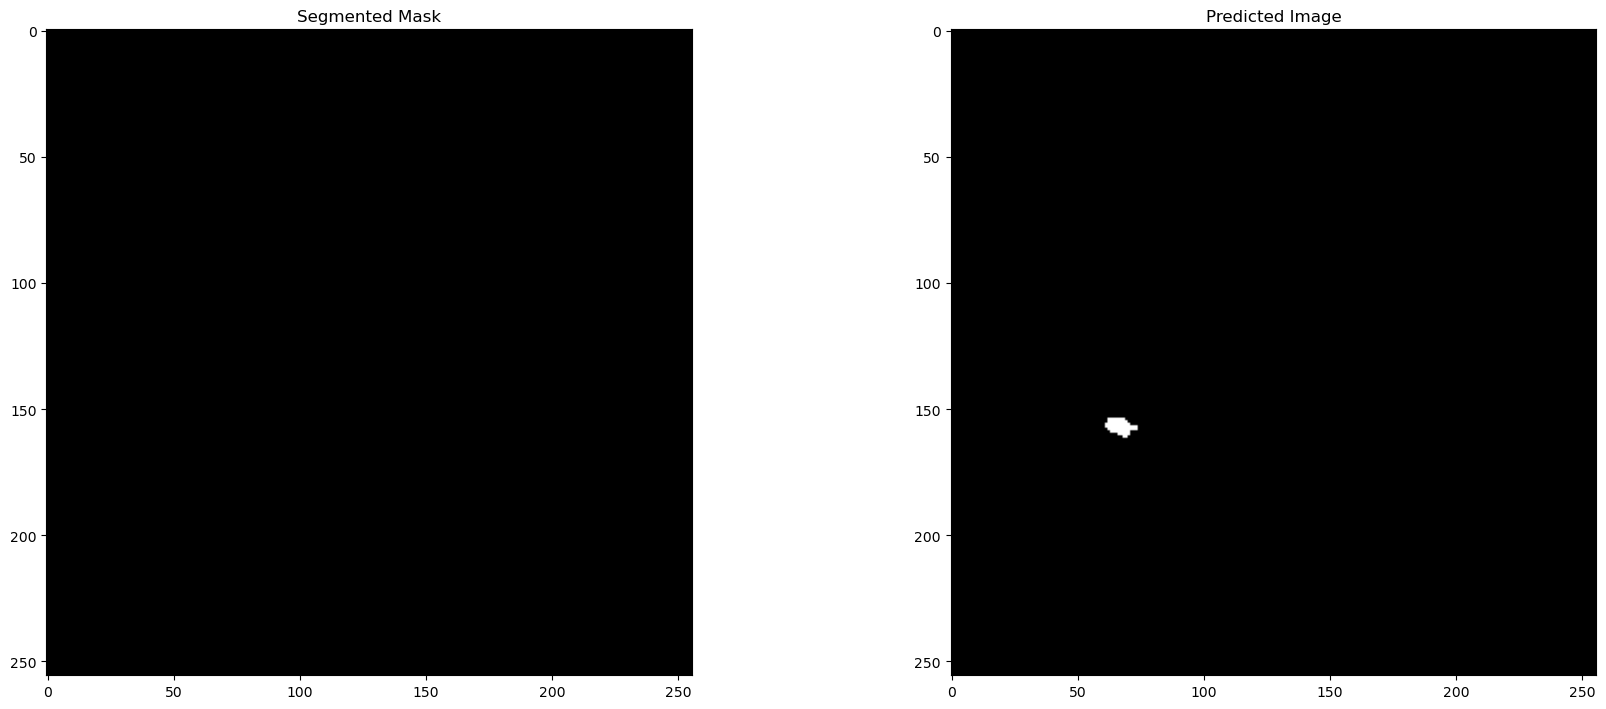

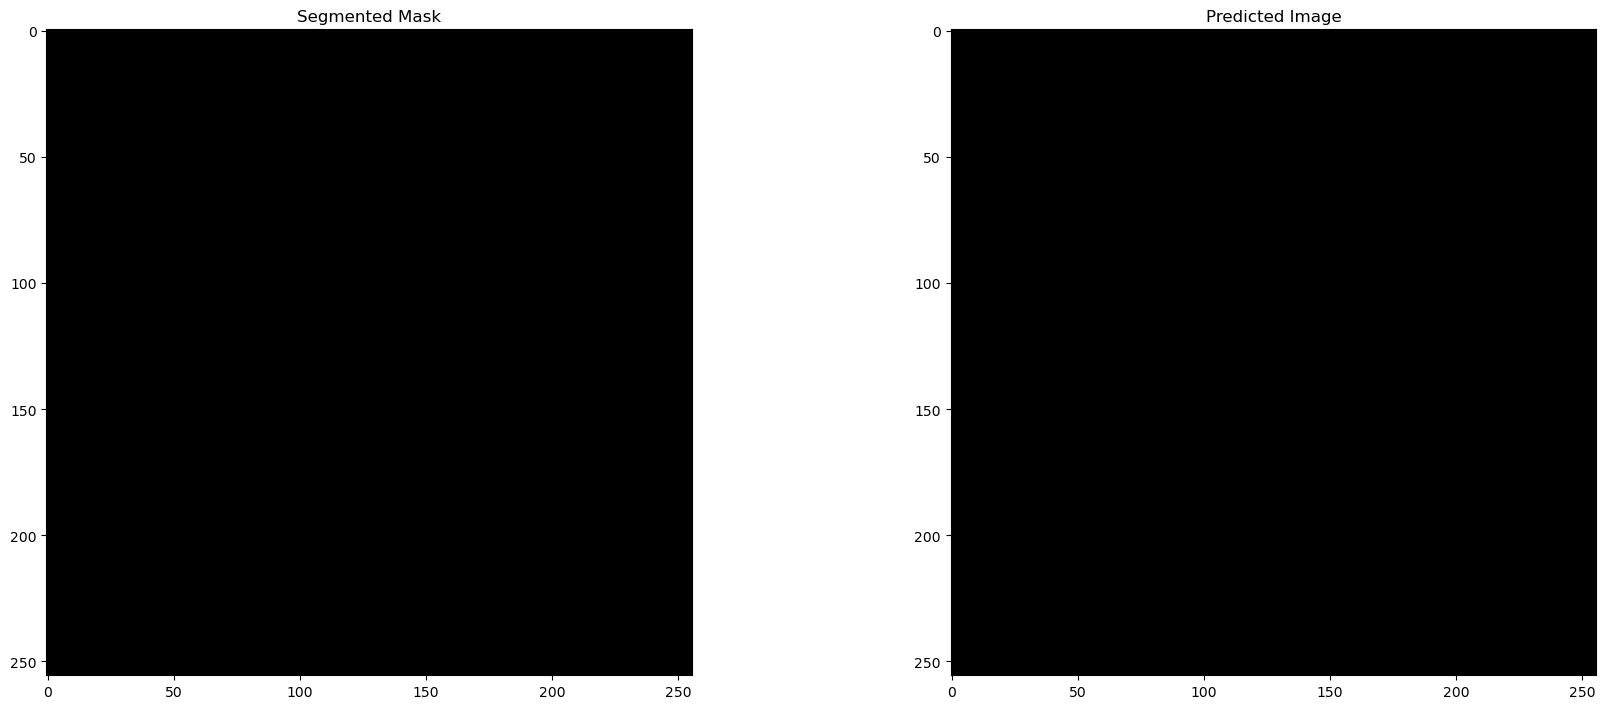

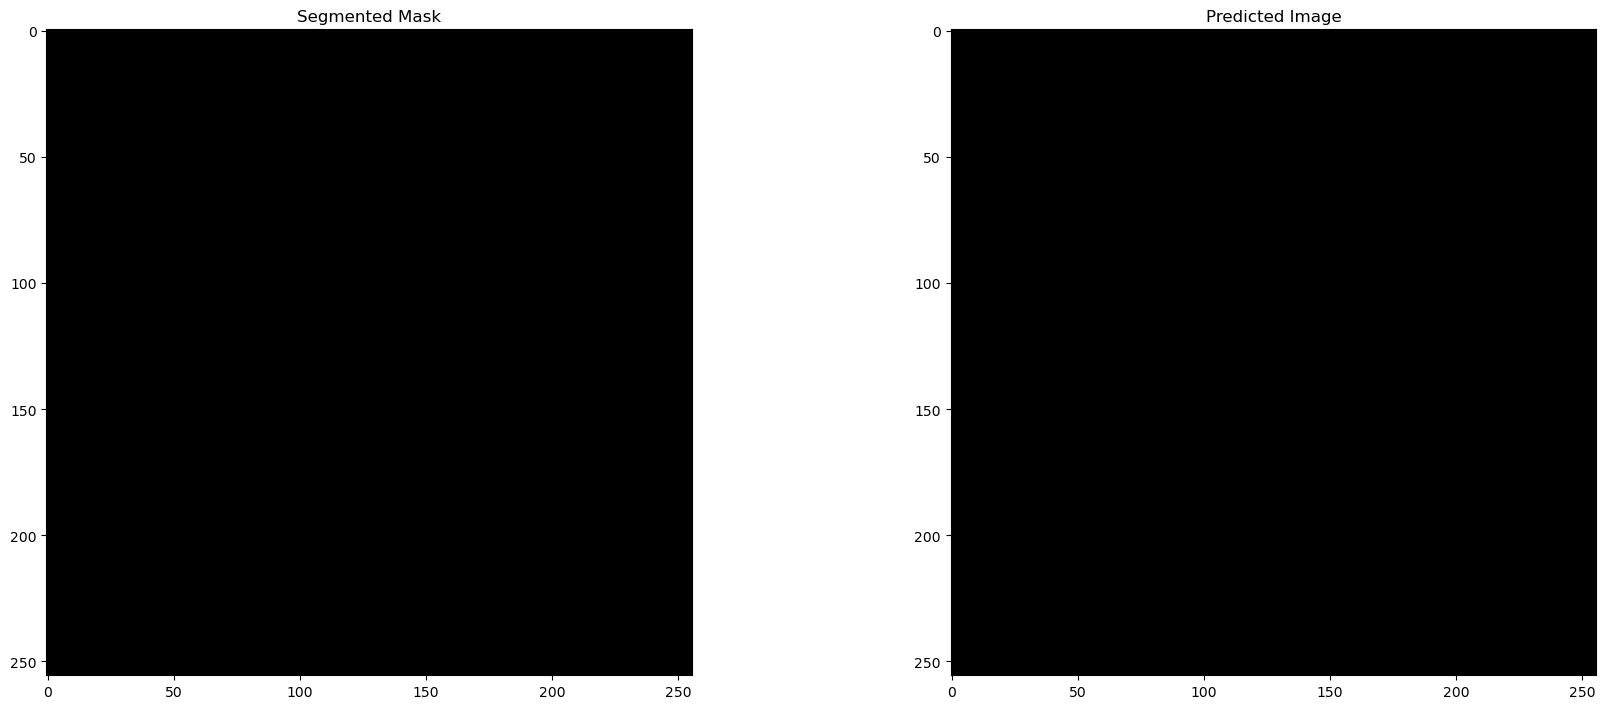

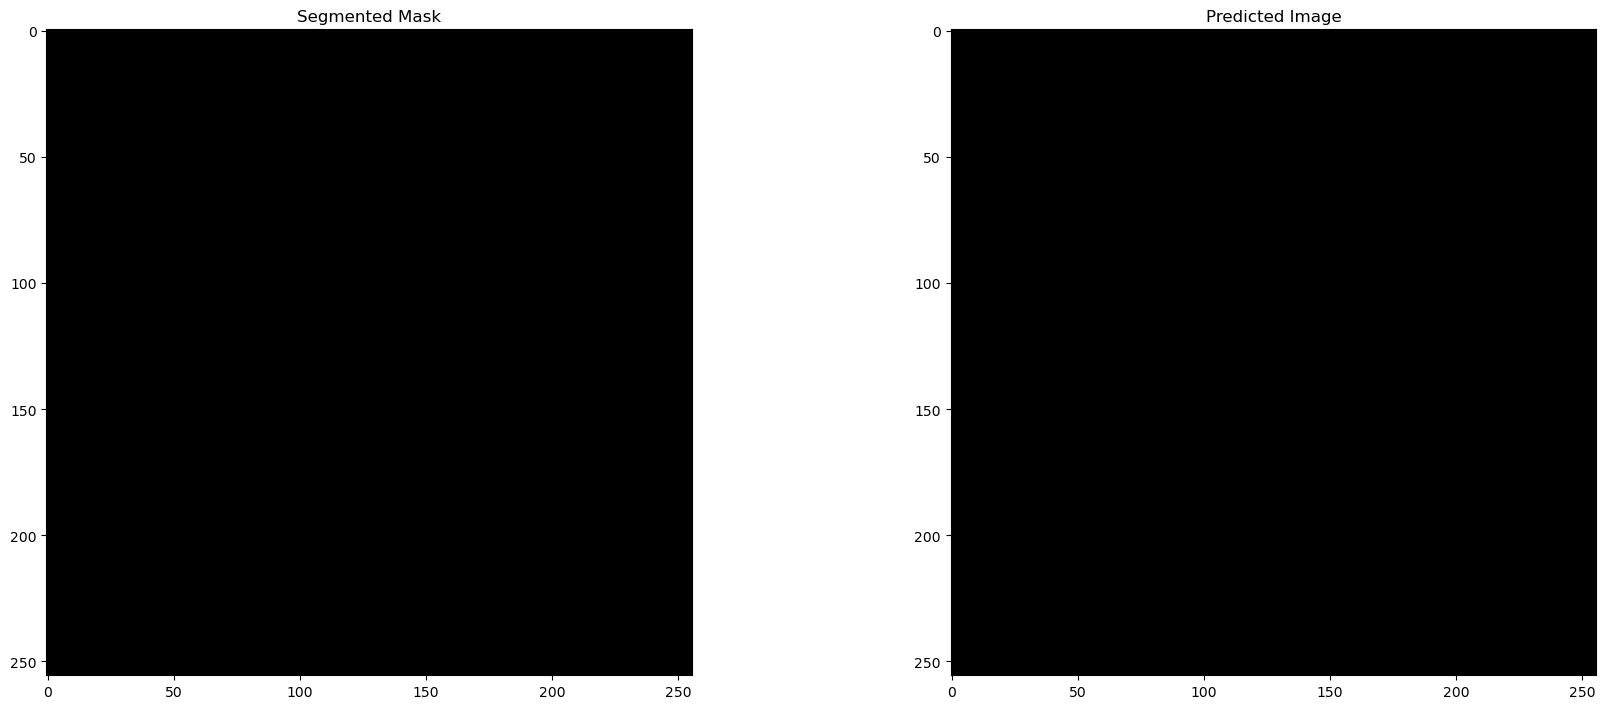

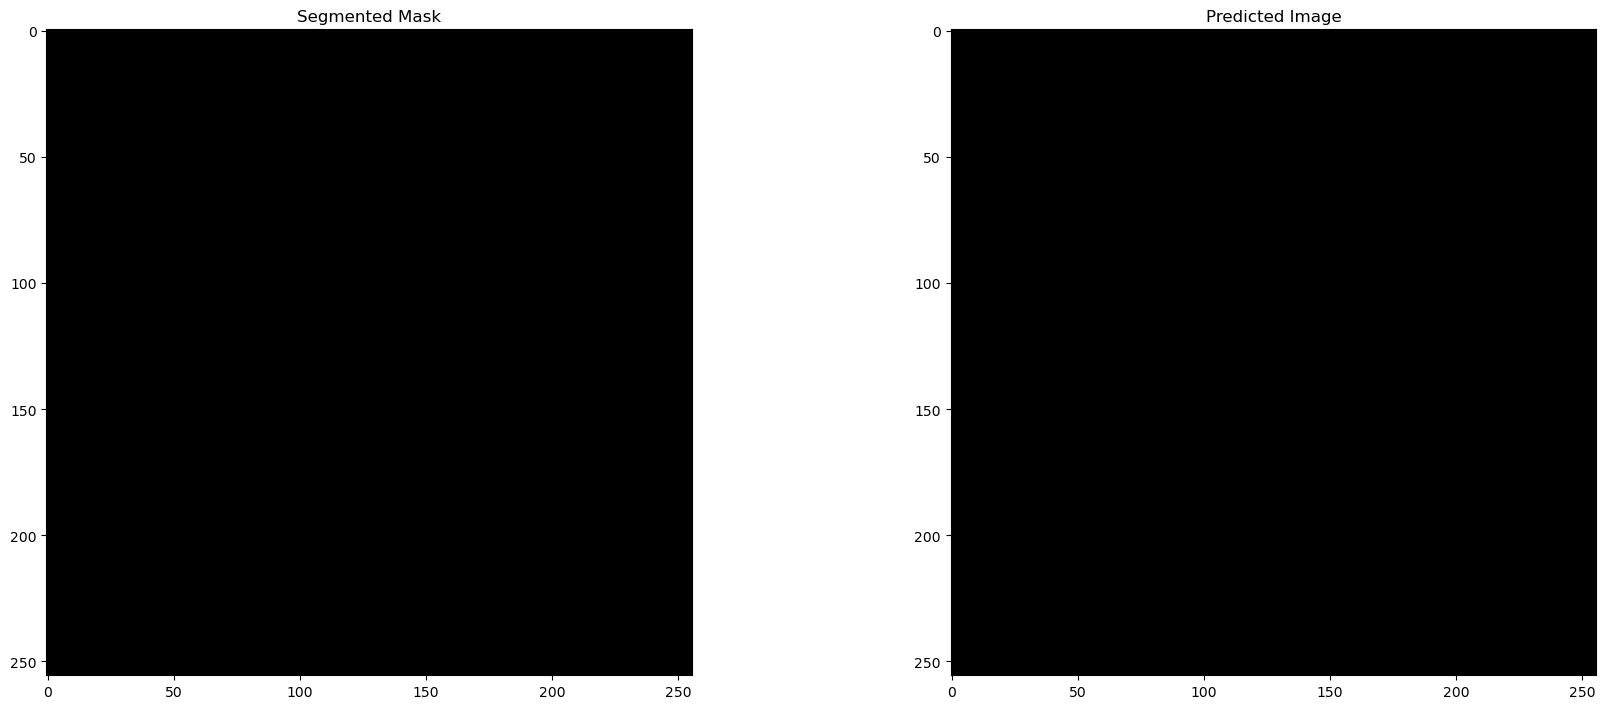

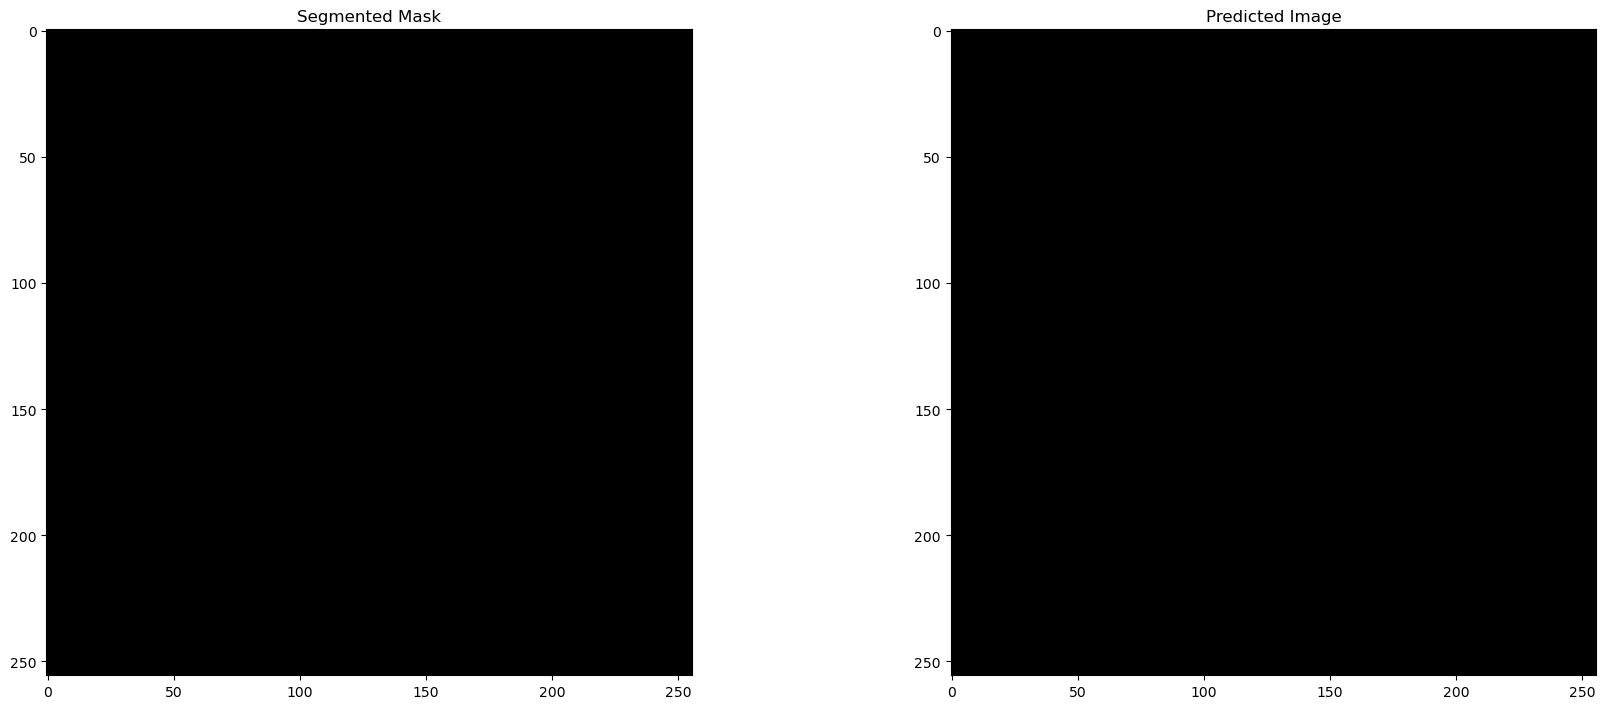

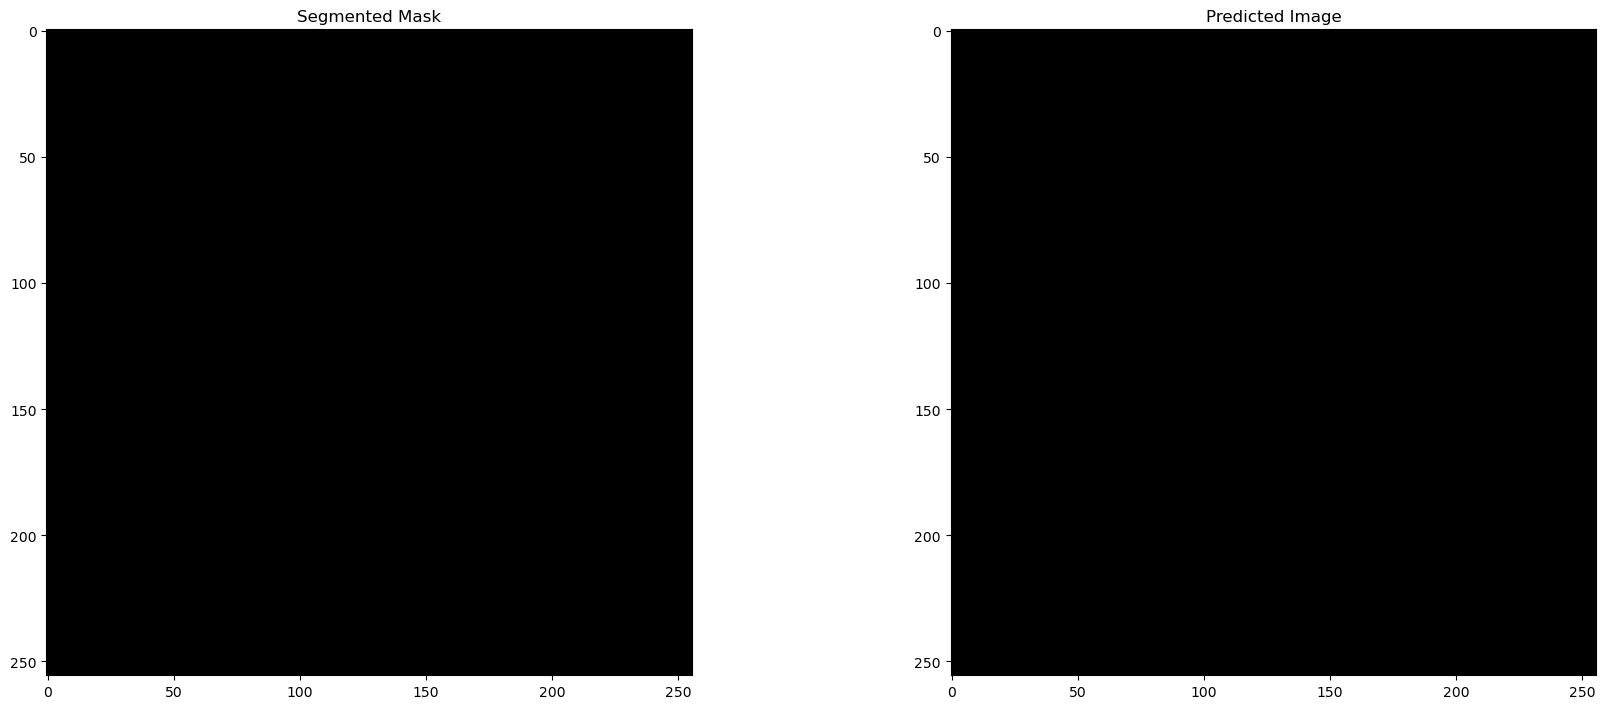

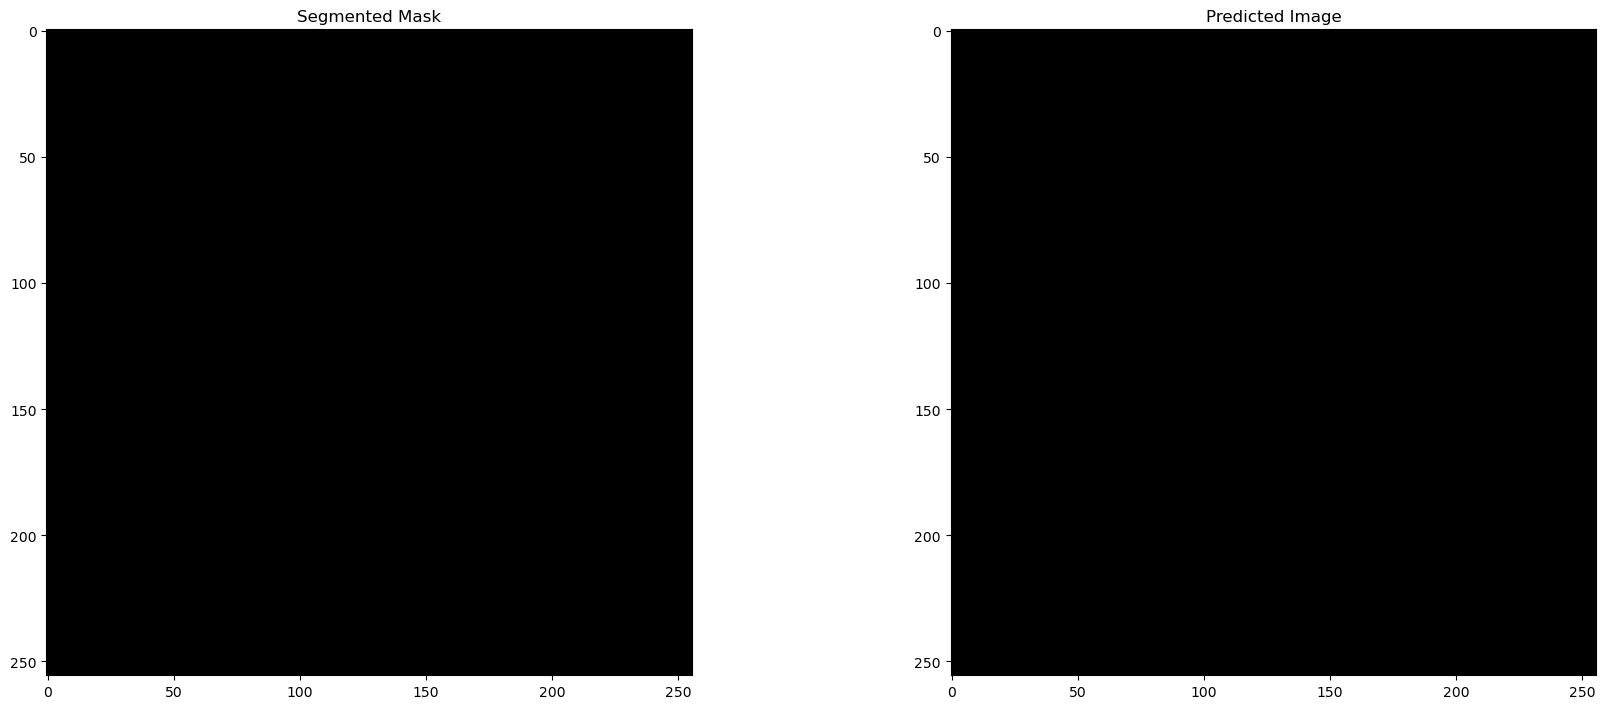

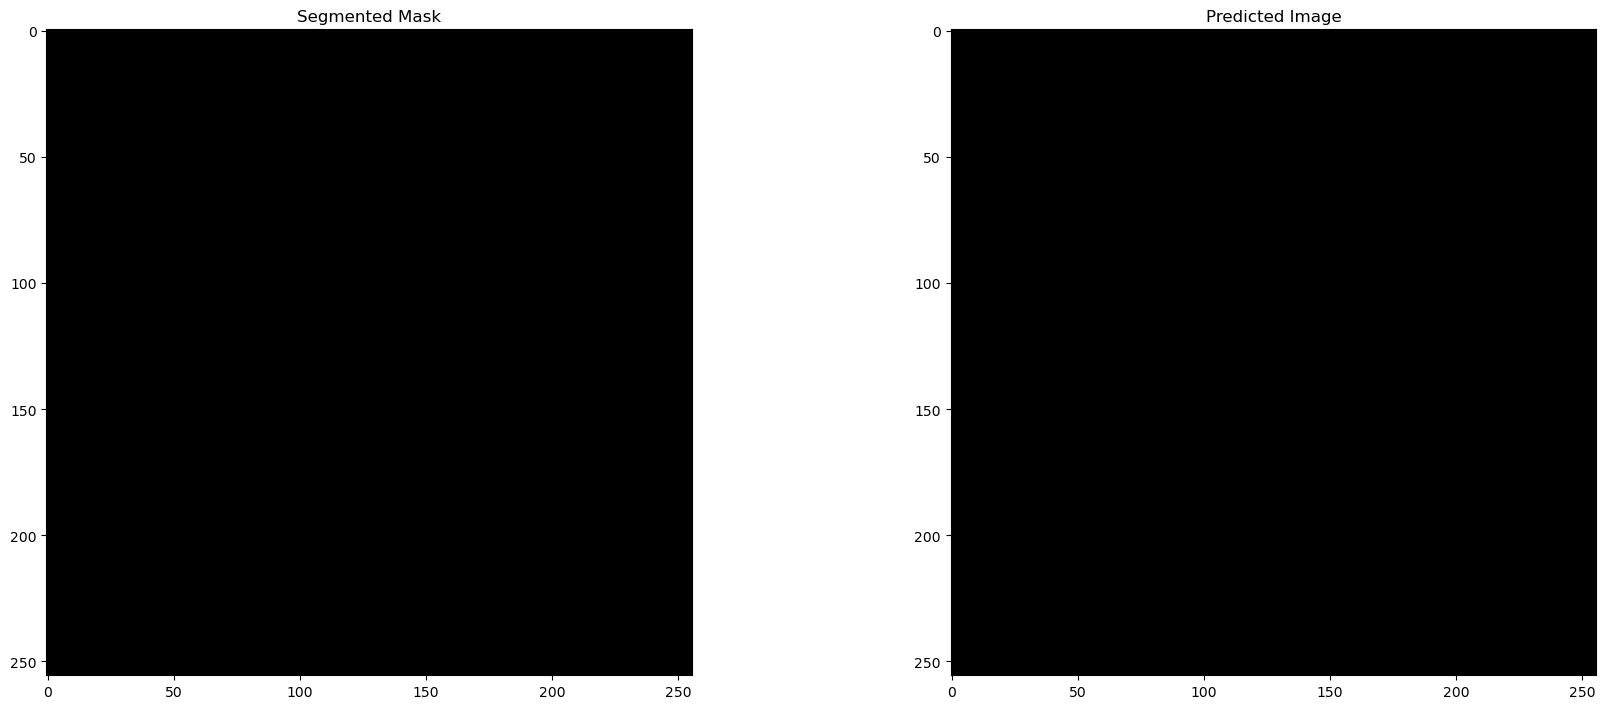

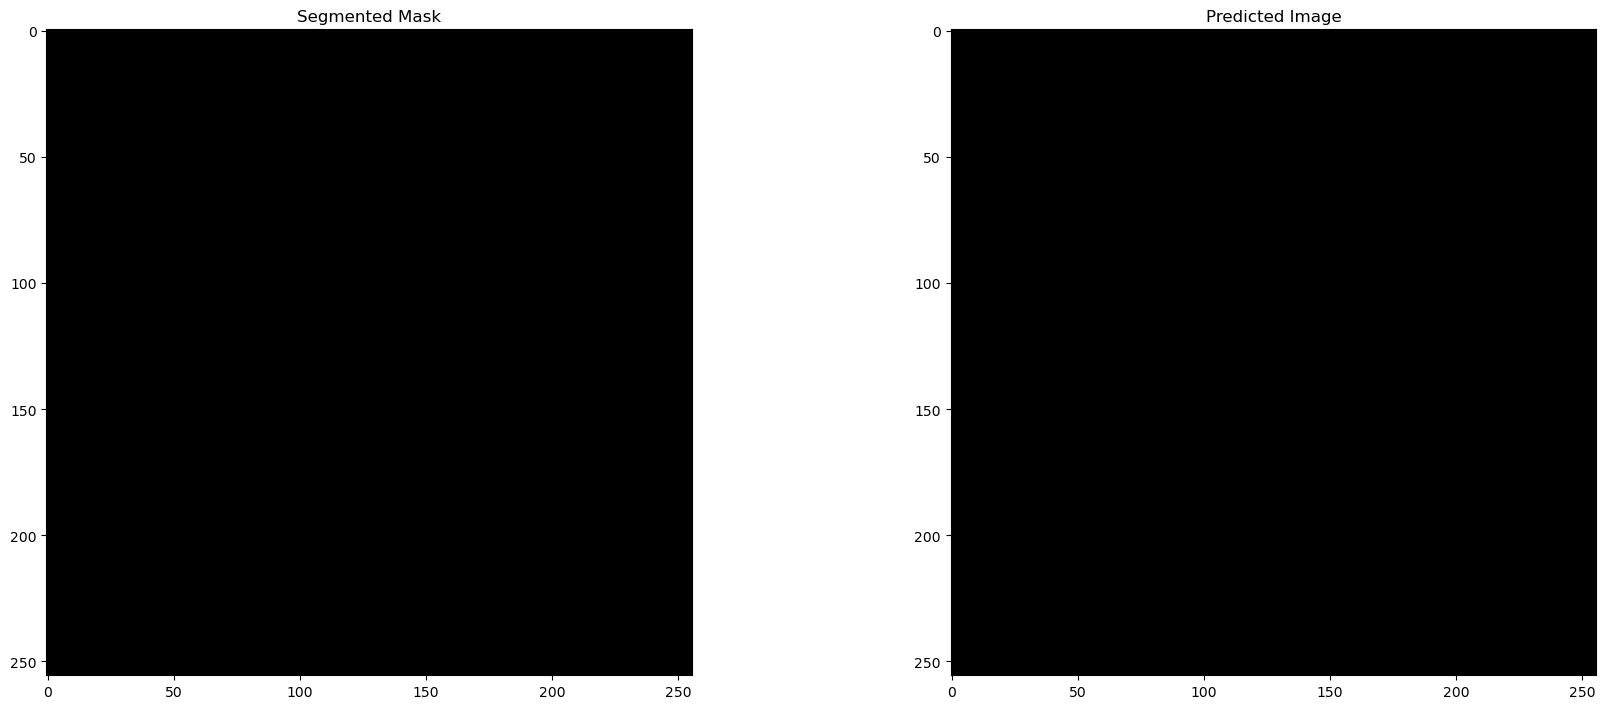

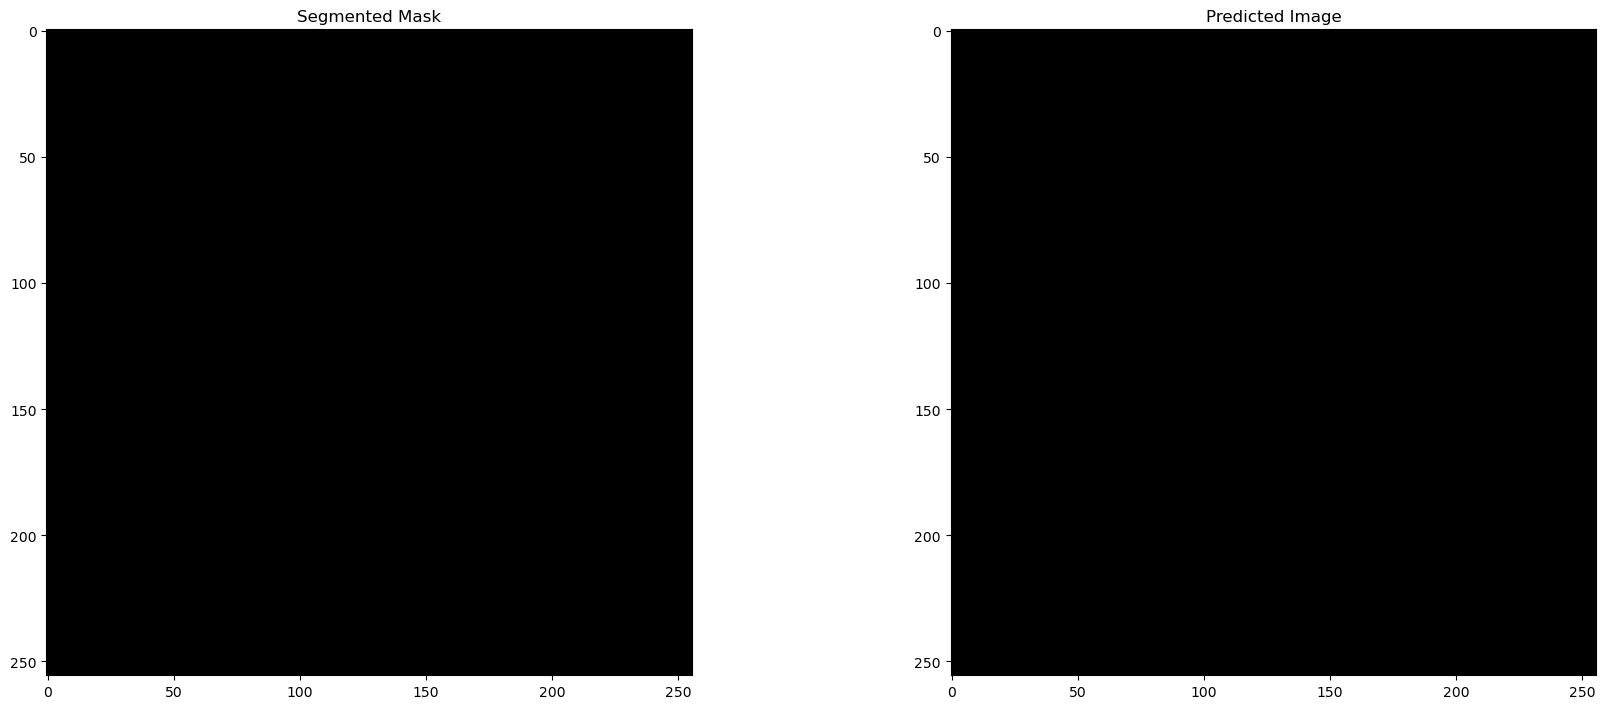

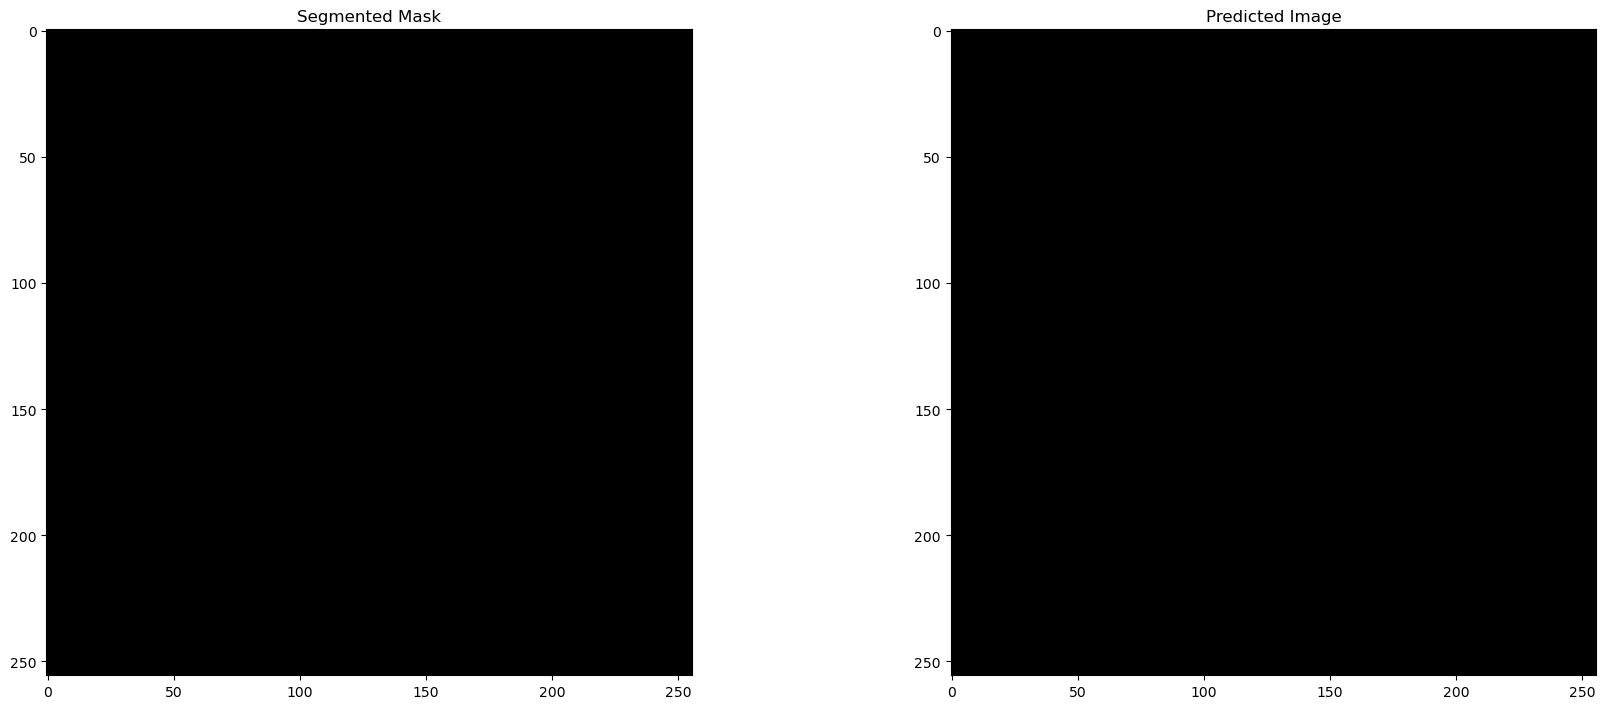

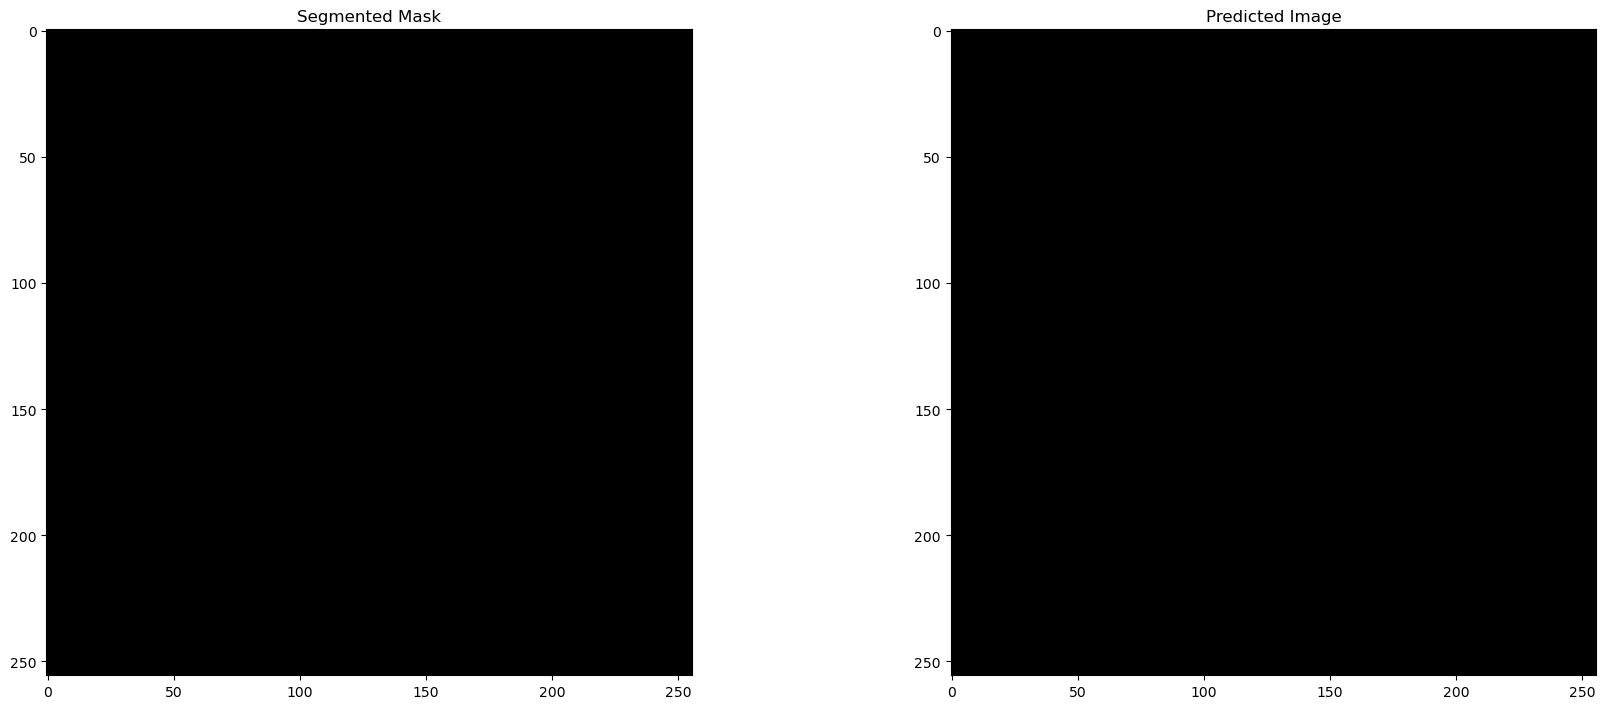

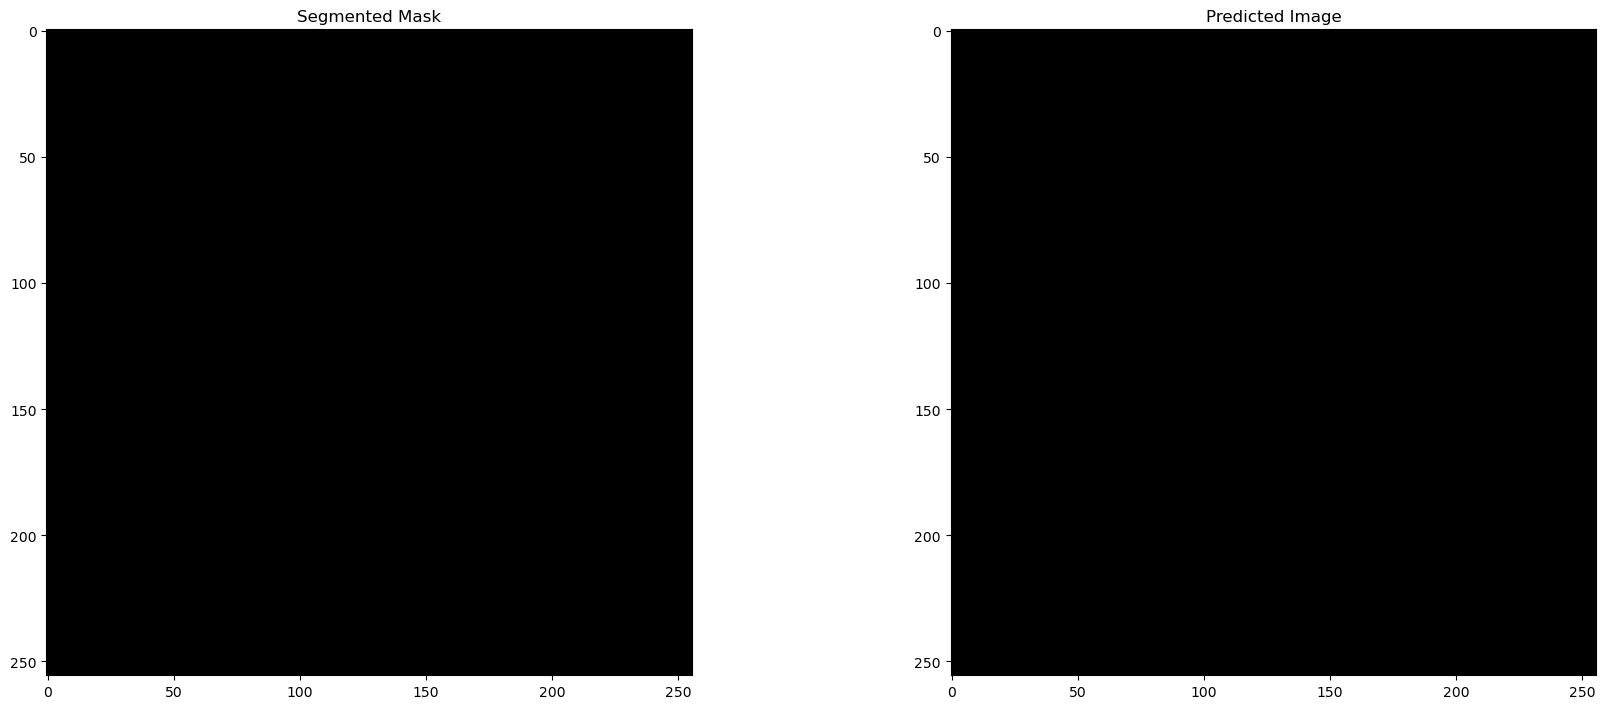

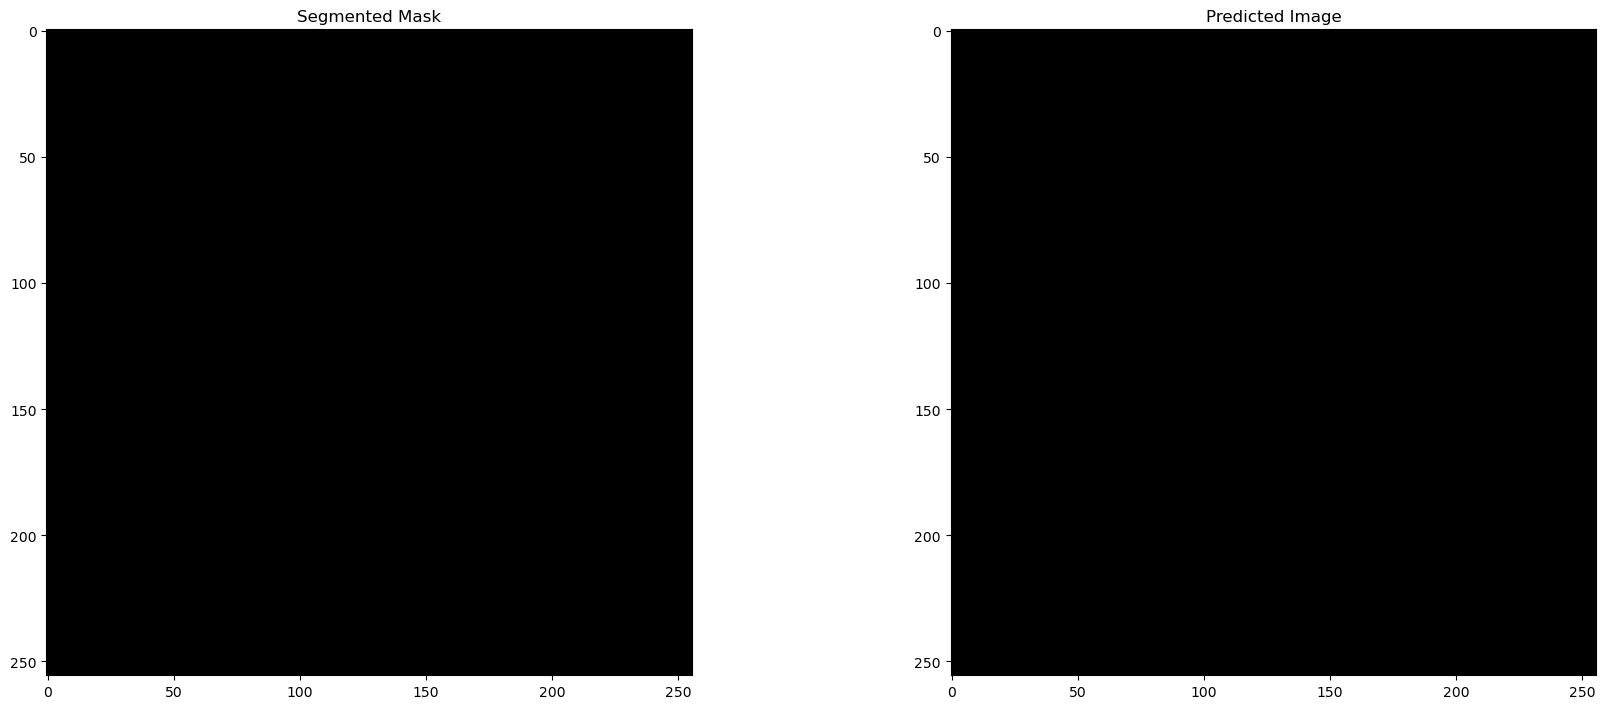

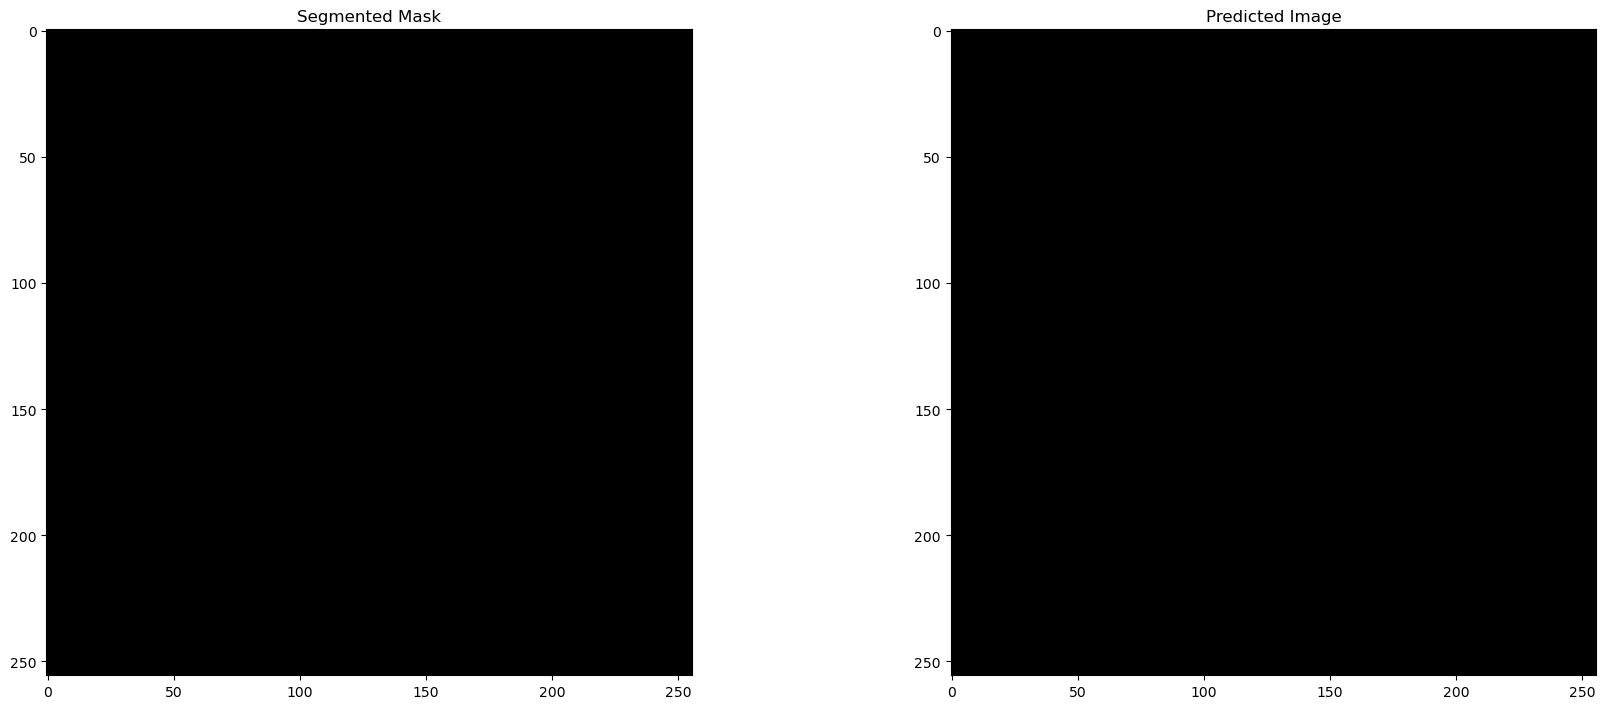

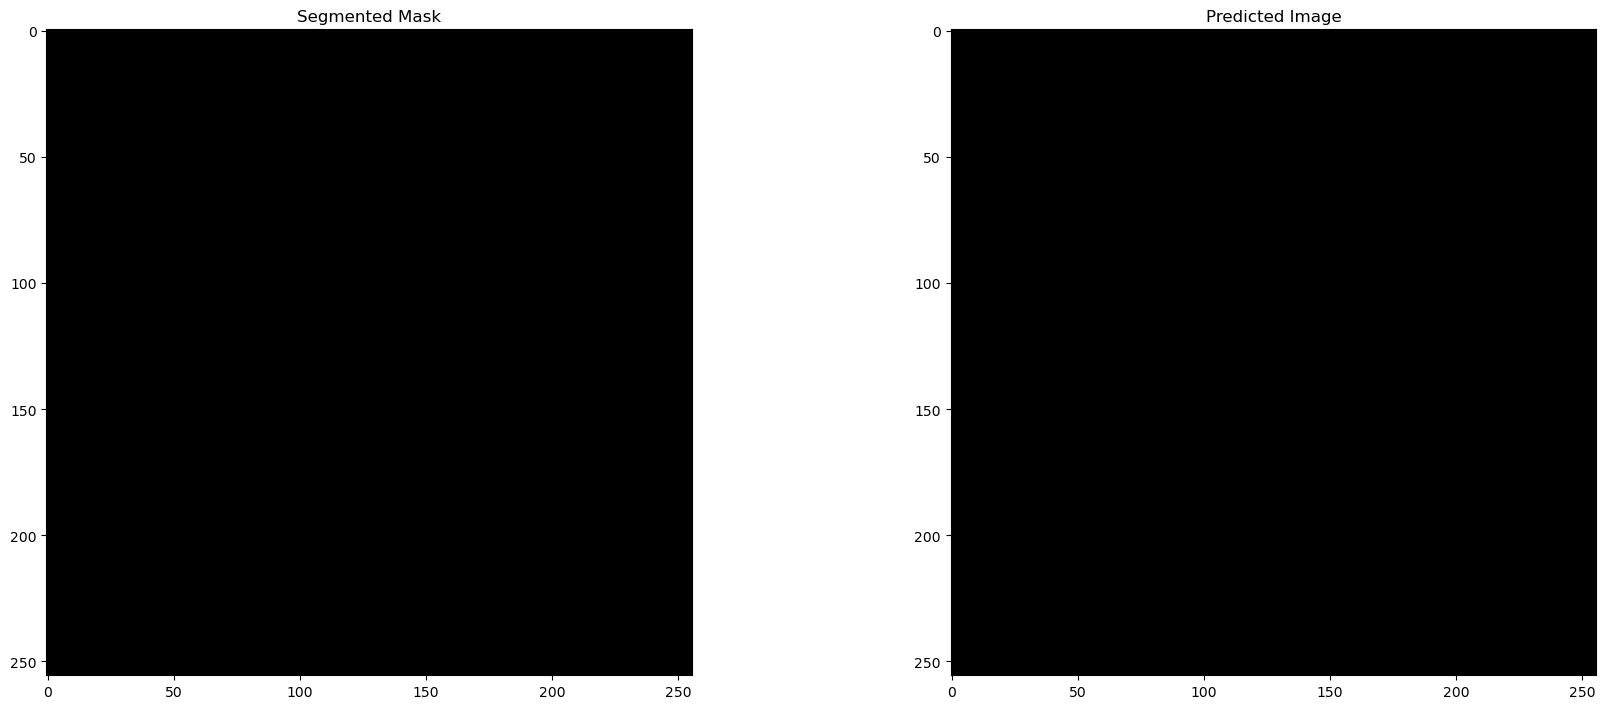

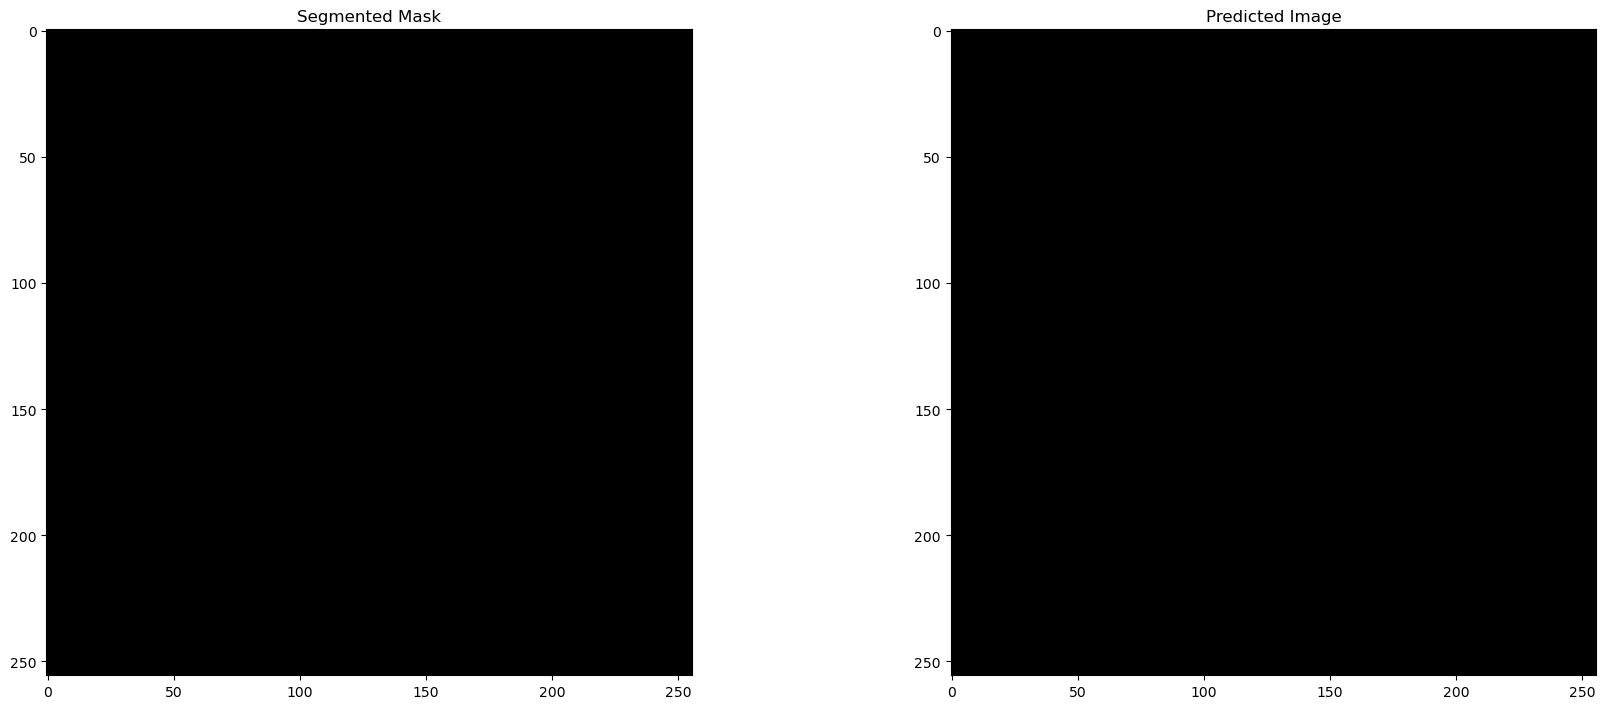

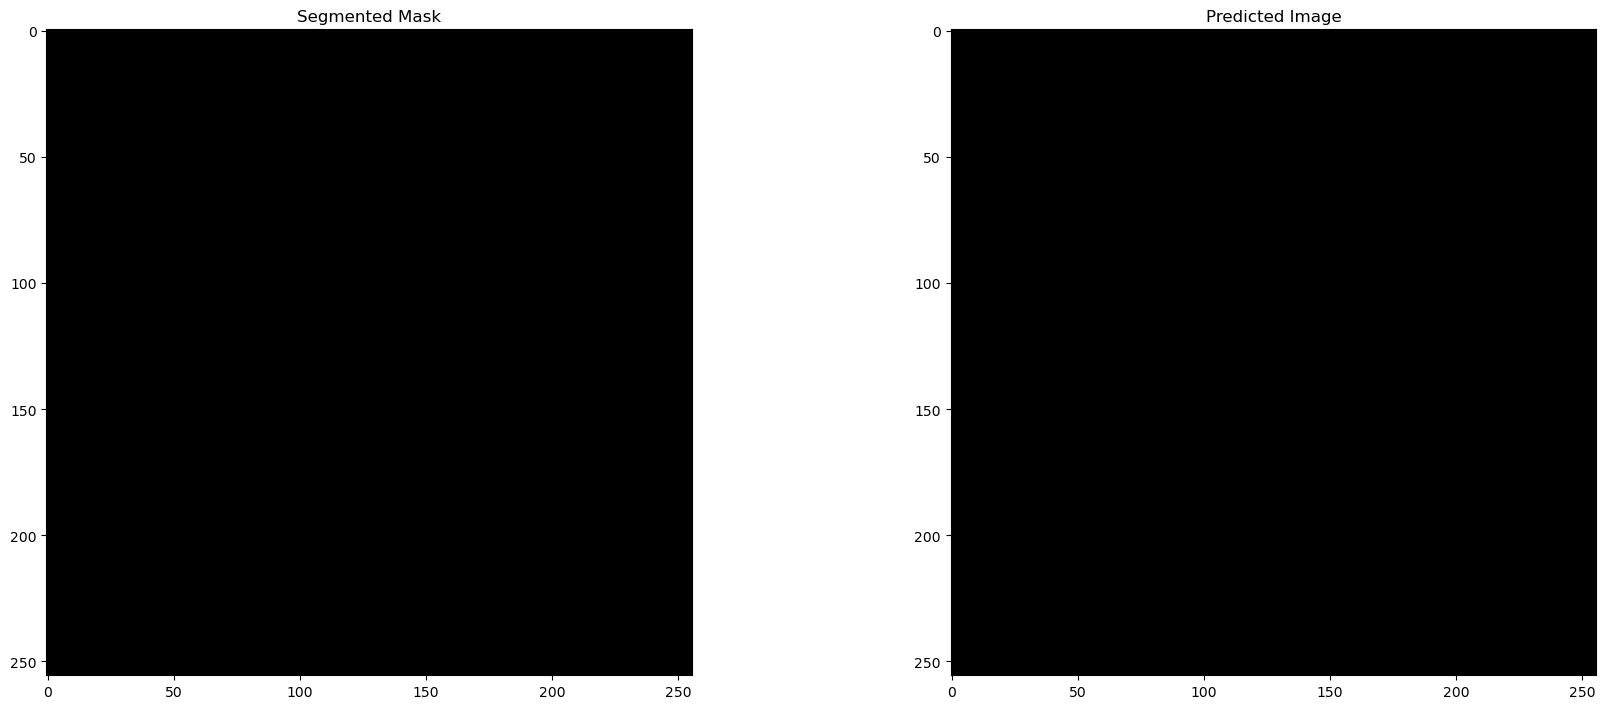

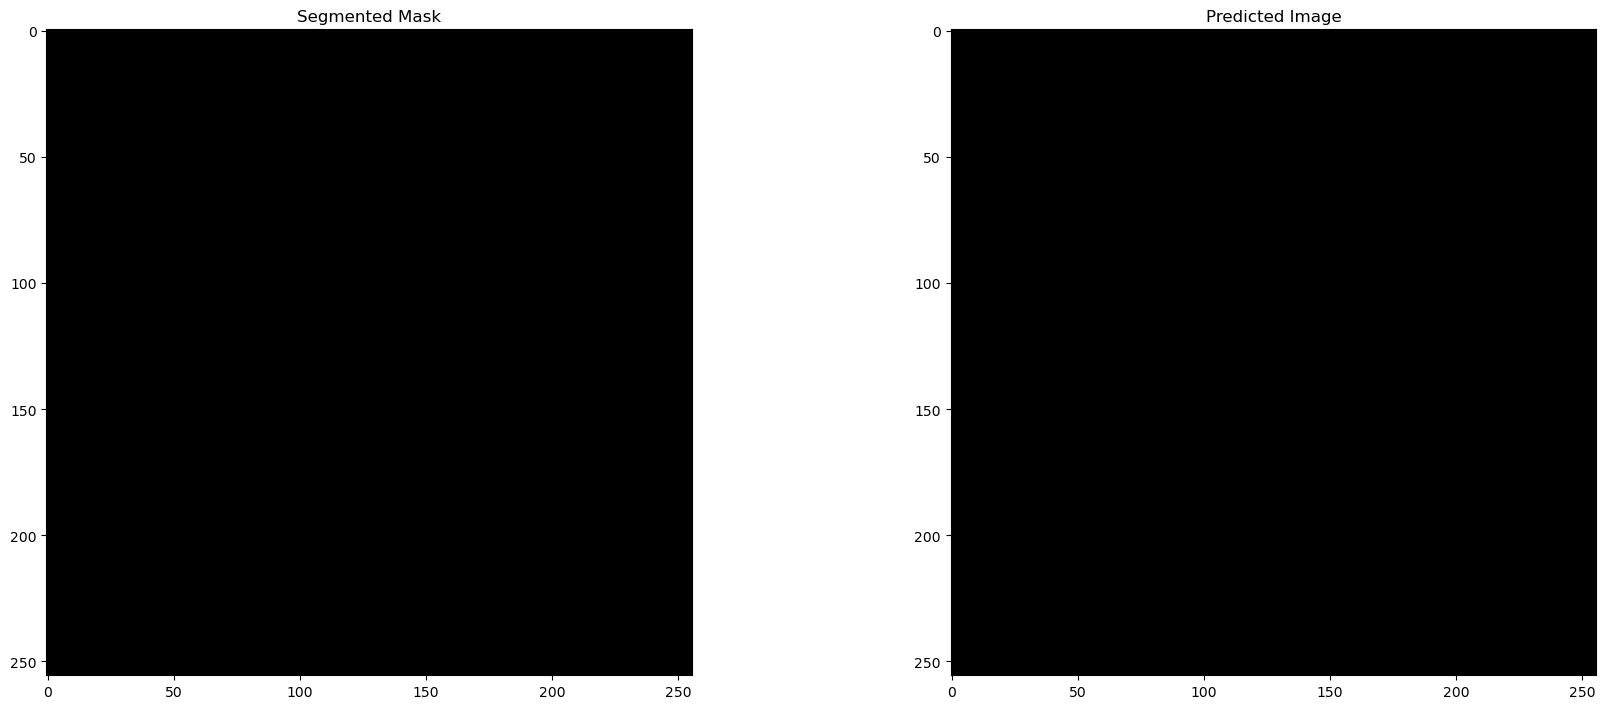

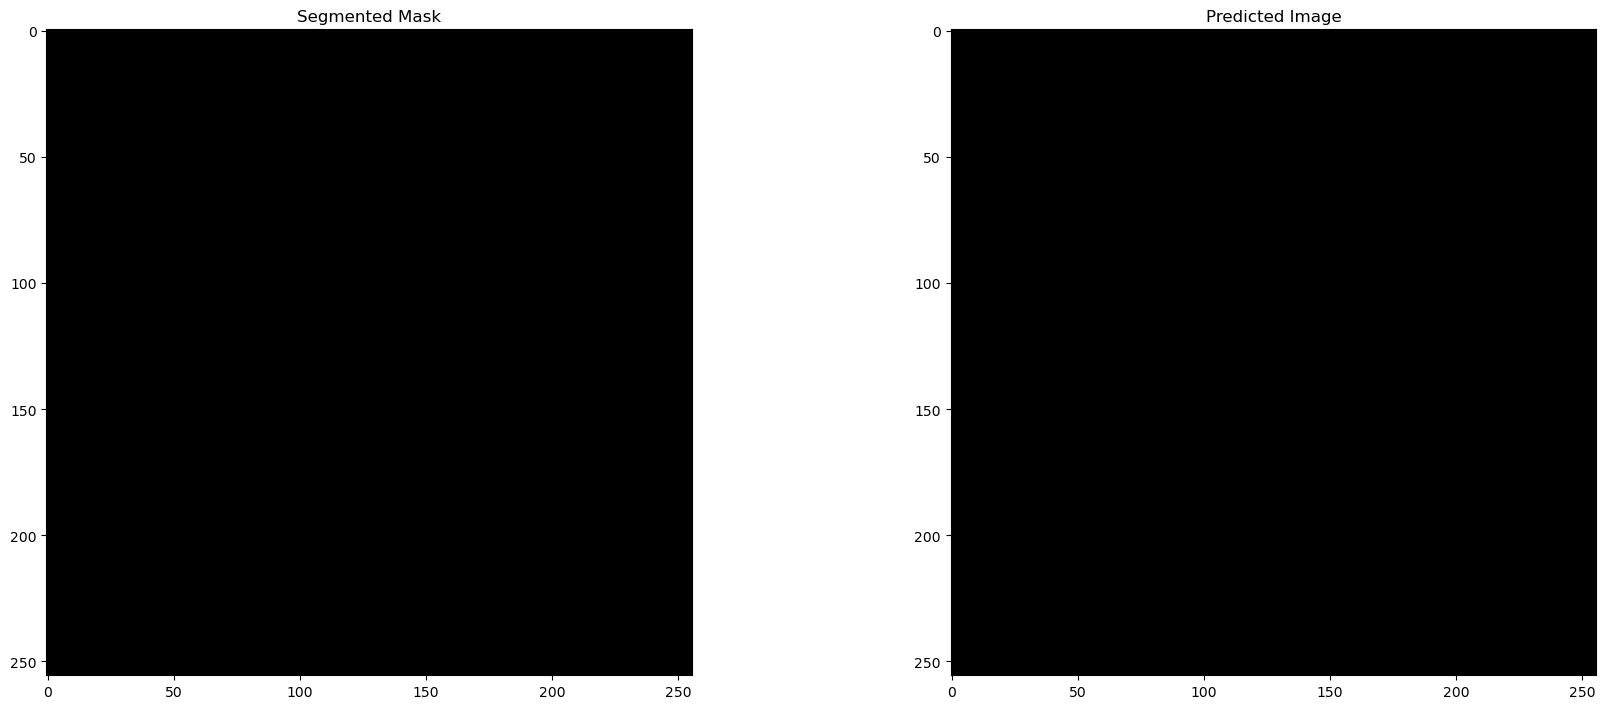

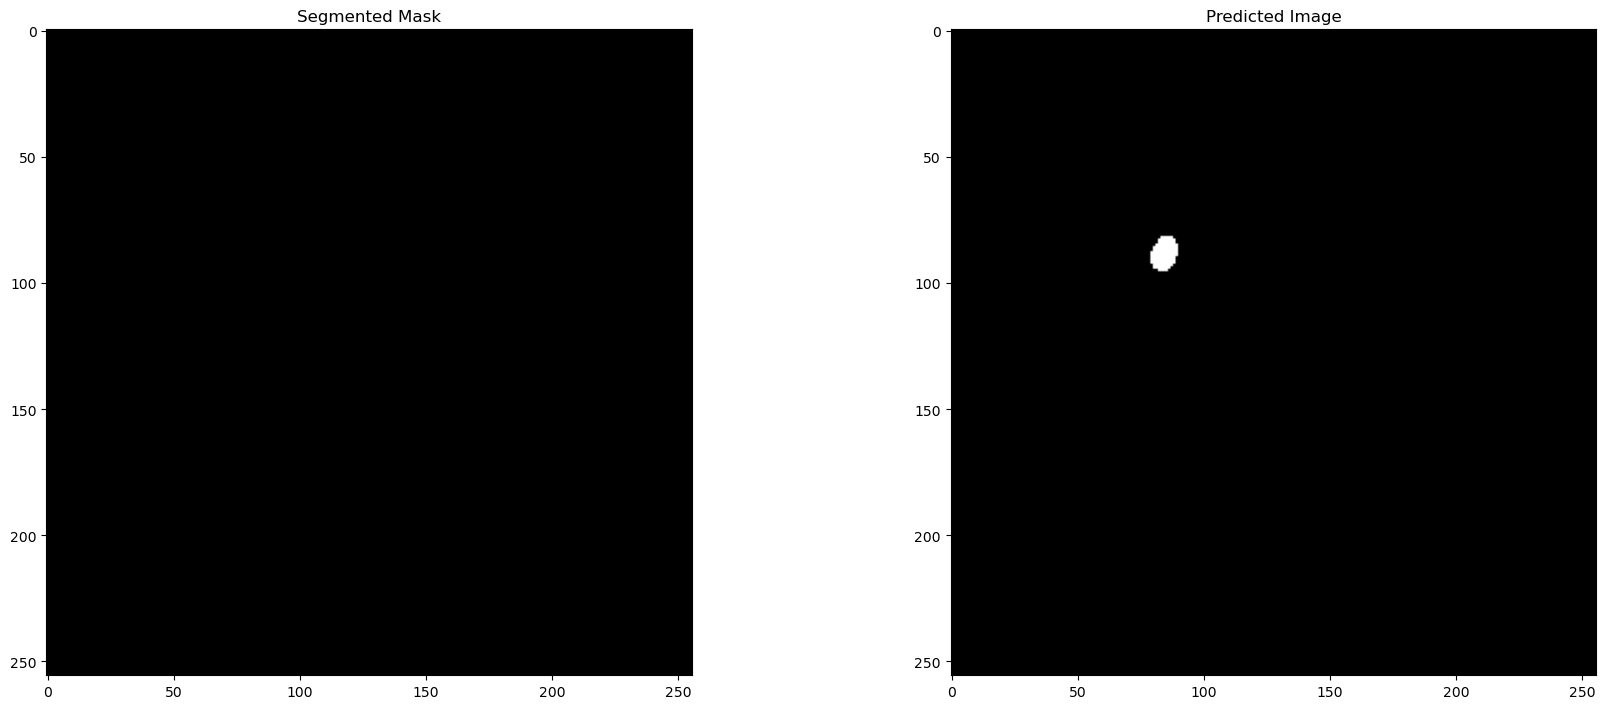

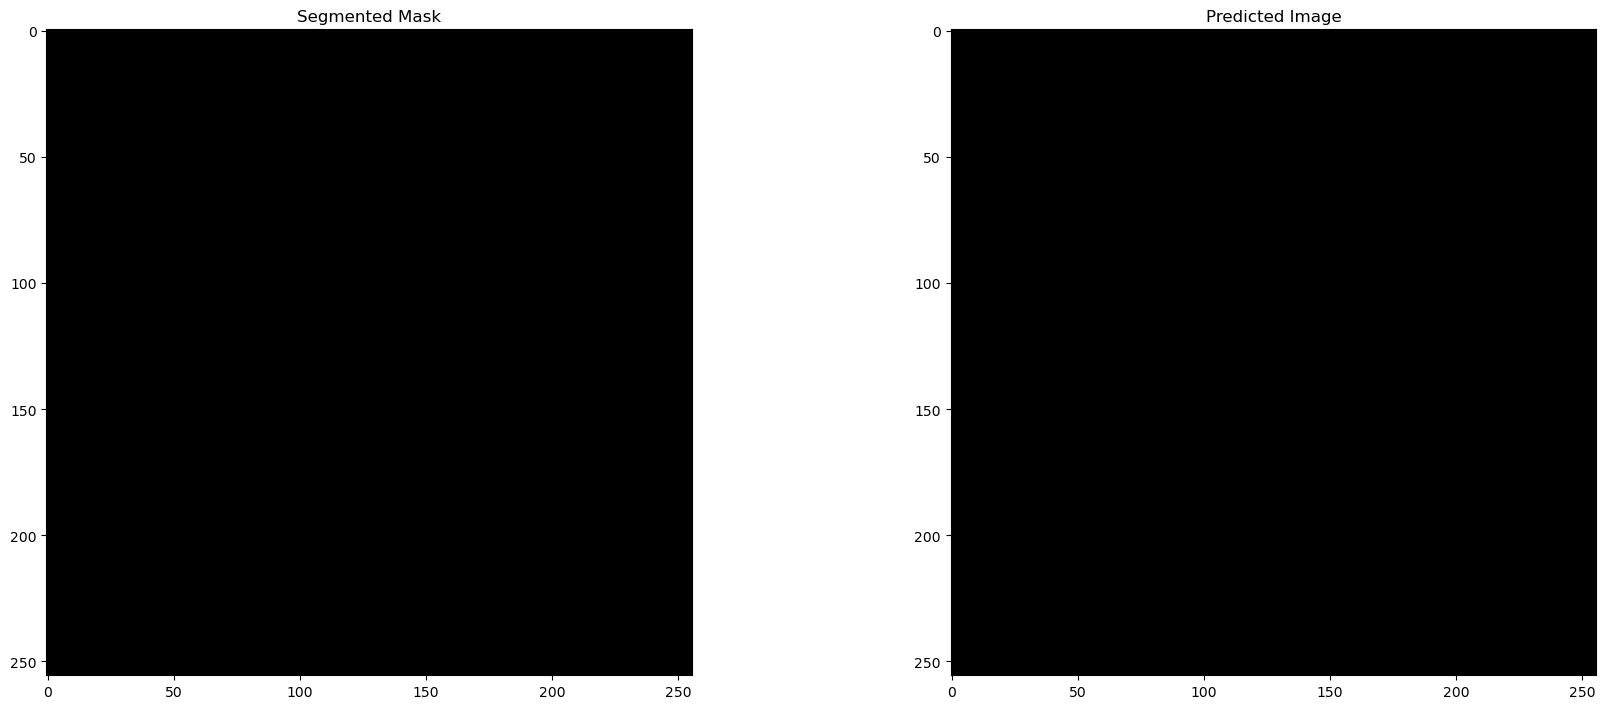

In [38]:
# imshow(np.reshape(y[2]*255, (image_size, image_size)), cmap="gray")
for i in range(1, 5, 1):
    ## Dataset for prediction
    x, y = valid_gen.__getitem__(i)
    result = model.predict(x)
    result = result > 0.5
#     print(id_name)
    for j in range(len(result)):
        fig = plt.figure(figsize=(20,20))
        fig.subplots_adjust(hspace=0.4, wspace=0.4)

        ax = fig.add_subplot(1, 2, 1)
        ax.imshow(np.reshape(y[j]*255, (image_size, image_size)), cmap="gray")
        ax.set_title("Segmented Mask")
#         ax.imshow(y[i])
        ax = fig.add_subplot(1, 2, 2)
        ax.imshow(np.reshape(result[j]*255, (image_size, image_size)), cmap="gray")
        ax.set_title("Predicted Image")

4
2
1/1 [==============================] - 2s 2s/step


[[64321     0]
 [  849   366]]
[64321     0   849   366]


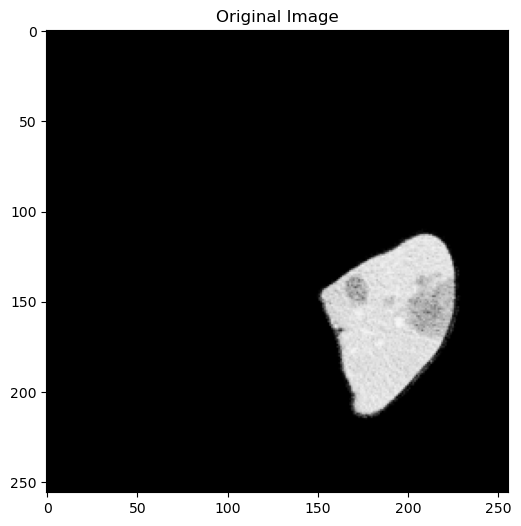

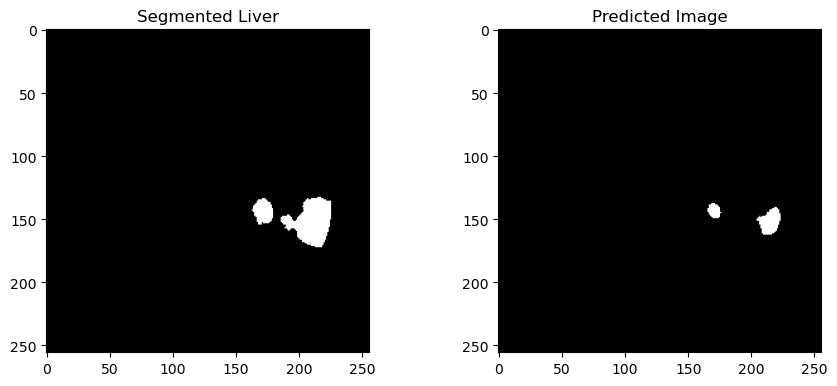

In [236]:
random_batch = random.randint(0, len(valid_ids)//batch_size - 1)
random_sample = random.randint(0, batch_size-1)
random_batch = 4
random_sample = 2
print(random_batch)
print(random_sample)
x, y = valid_gen.__getitem__(10)
result =  model.predict(x)
result = result > 0.9

fig2 = plt.figure(figsize=(6,6))
ax2 = fig2.add_subplot(1,1,1)
ax2.imshow(x[random_sample])
ax2.set_title("Original Image")

fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 2, 1)
ax.imshow(np.reshape(y[random_sample]*255, (image_size, image_size)), cmap="gray")
ax.set_title("Segmented Liver")
# ax.imshow(y[i])
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.reshape(result[random_sample]*255, (image_size, image_size)))
ax.set_title("Predicted Image")

# imshow(np.reshape(y[random_sample]*255, (image_size, image_size)), cmap="gray")
cm_2d = confusion_matrix(y[random_sample].flatten(), result[random_sample].flatten())
cm = cm_2d.ravel()

# (tn, fp, fn, tp)
print(cm_2d)
print(cm)

In [237]:
print("Pixel Accuracy " + str(((cm[3]+cm[0])/(cm[3]+cm[0]+cm[1]+cm[2])*100))+'%' )
print("True Positive Accuracy " + str(((cm[3])/(cm[3]+cm[2])*100))+'%' )
print("Dice Coefficient " + str((2*(cm[3])/(2*cm[3]+cm[2]+cm[1])*100))+'%' )

Pixel Accuracy 98.70452880859375%
True Positive Accuracy 30.12345679012346%
Dice Coefficient 46.29981024667932%


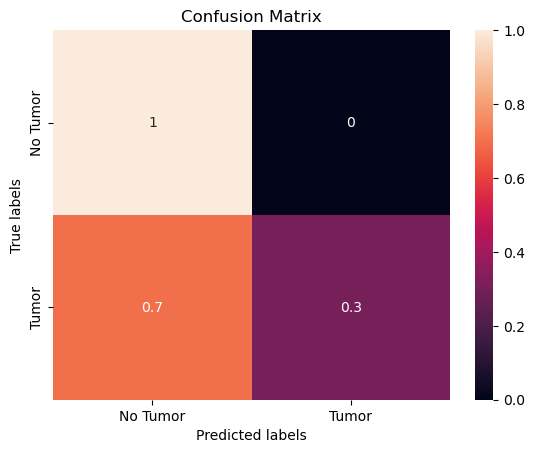

In [238]:
ax= plt.subplot()
cm_2d = cm_2d.astype('float') / cm_2d.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_2d, annot=True, ax = ax); #annot=True to annotate cells

# print(count_cms)
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No Tumor', 'Tumor']); ax.yaxis.set_ticklabels(['No Tumor', 'Tumor']);



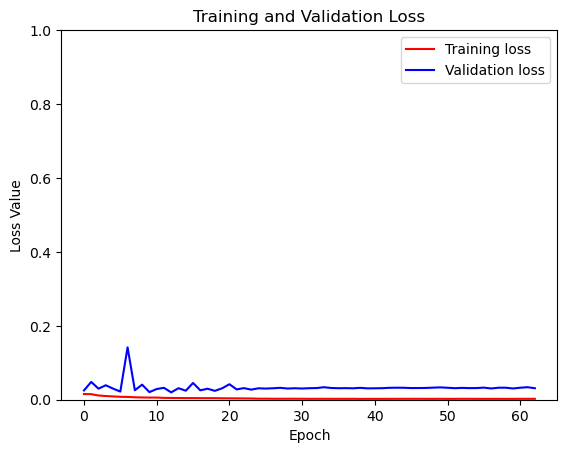

In [242]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

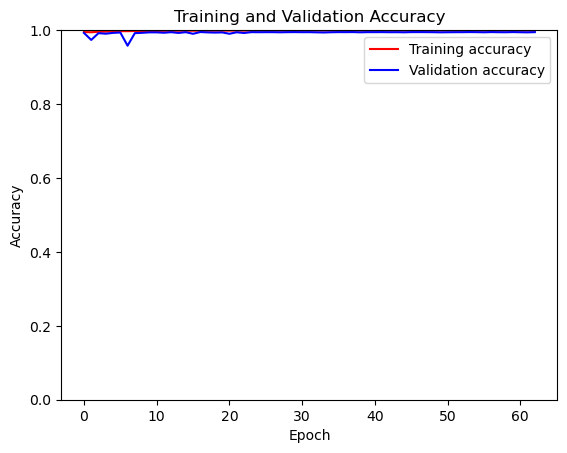

In [241]:
# Access training and validation accuracy values from the 'history' attribute
accuracy = model_history.history['acc']
val_accuracy = model_history.history['val_acc']

plt.figure()
plt.plot(range(len(accuracy)), accuracy, 'r', label='Training accuracy')
plt.plot(range(len(val_accuracy)), val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend()
plt.show()
